# **FNCE 2370 Project: Startup Success Prediction**

# Introduction

Accurately predicting startup success is central to venture capital (VC). The difficulty behind this is understanding which startups are primed to thrive, and consistently identifying them. A 2018 study describes the failure rate of startups– of those that started in 2014, only 56% made it to the fifth year. That is, 44% fail within the first 4 years of their inception. For an investor, these statistics are far from ideal. Other studies go as far as to state: “around 90% of startups are unsuccessful”. Yet, venture capitalists still heavily invest in startups, despite “the typical loss rate for early-stage investments being 65%. This means that 35% must generate gains much greater than 1x to achieve an acceptable overall result”. These numbers point to the fact that startups can be extremely risky investments, especially if not carefully researched.

Furthermore, knowing what impacts the success of a startup also benefits entrepreneur hopefuls who are just starting out. Being informed on factors such as the best places to found a startup, the number of participants, and the level of funding necessary helps influence entrepreneurs to put themselves in the best position possible to succeed. As computer science students interested in starting or joining early stage tech startups and VC funds, we are personally invested in finding out what features make a startup successful. We hope to use the results of our project to aid in our recruitment process and potentially in our future startup pursuits.

This sets up the motivations behind our project - to understand the key factors critical to startup success by developing a machine learning model that is able to predict the likelihood of success of a startup, given key data such as its location, industry verticals, funding, and more. The ultimate goal of this project is to develop an accurate model, such that we minimize the number of false positive predictions, as these are more costly in real life (i.e. investing in a startup that is predicted to succeed but actually fails).

We will work with a [dataset](https://www.kaggle.com/datasets/manishkc06/startup-success-prediction) compiled by GMO, an investment management firm based in Boston. The data contains company information, investment insights, and industry trends of the startups operating between 2005 and 2012.

**Research Questions**

- Can we predict the likelihood of success for a given startup in the US? 
- If so, which factors are most important for a startup to succeed?

**Hypotheses**

- Null hypothesis: features like location, industry verticals, series funding, etc. do not impact the success of a startup. This would be indicated by a correlation coefficient between the response variable (success of a startup) and the explanatory variables that is not statistically significant.

- Our alternate hypothesis is that features such as location, industry verticals, series funding do impact the success of a startup.

- We predict that the null hypothesis will hold. The rationale behind this is that if it’s possible to accurately predict the success of startups based on simple features, we would rarely see VC funds investing in startups that fail. Additionally, our set of features can’t fully encapsulate all of the qualitative values that help startups succeed such as the level of experience of the founder.


In [215]:
# Library Setup
import json
import glob
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from matplotlib import cm
from google.colab import drive
from google.colab import files
from string import ascii_letters
from lxml import html
from scipy.optimize import minimize
import sys
from datetime import datetime
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as ss
import plotly.express as px
import scipy.stats as stats
! pip install geopandas
! pip install Shapely
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [216]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, plot_precision_recall_curve, roc_curve, roc_auc_score, fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedShuffleSplit, train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.api as sm
from sklearn import svm
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [217]:
SEED = 24
TOL = 1.0e-8

In [218]:
# Upload API file (kaggle.json)
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"winniedong2","key":"31a77945bae2243b7ff65d0a143a975f"}'}

In [219]:
# Download datasets from Kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download manishkc06/startup-success-prediction
! unzip startup-success-prediction.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
startup-success-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  startup-success-prediction.zip
replace startup data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [220]:
# Read dataset into Pandas Dataframes
df = pd.read_csv('startup data.csv')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data Cleaning
First, we will visualize our dataframes and explore basic characteristics and features of our dataset.

In [221]:
# Explore head of the dataset
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.36,-71.06,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.25,3.00,4.67,6.70,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.00,0,acquired
1,204,CA,37.24,-121.97,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.13,10.00,7.01,7.01,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.75,1,acquired
2,1001,CA,32.90,-117.19,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.03,1.03,1.46,2.21,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.00,1,acquired
3,738,CA,37.32,-122.05,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.13,5.32,6.00,6.00,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.33,1,acquired
4,1002,CA,37.78,-122.42,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.00,1.67,0.04,0.04,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.00,1,closed


In [222]:
# Shape of the dataset
df.shape

(923, 49)

In [223]:
df.columns

Index(['Unnamed: 0', 'state_code', 'latitude', 'longitude', 'zip_code', 'id',
       'city', 'Unnamed: 6', 'name', 'labels', 'founded_at', 'closed_at',
       'first_funding_at', 'last_funding_at', 'age_first_funding_year',
       'age_last_funding_year', 'age_first_milestone_year',
       'age_last_milestone_year', 'relationships', 'funding_rounds',
       'funding_total_usd', 'milestones', 'state_code.1', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA',
       'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants',
       'is_top500', 'status'],
      dtype='object')

In [224]:
# Drop uninterpretable columns upon exploring the column names
df = df.drop(columns=['Unnamed: 0','Unnamed: 6','labels','object_id'])

In [225]:
# Check whether state_code and state_code.1 are duplicates
# There is a discrepancy between two columns for one row
df[df['state_code']!=df['state_code.1']]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
515,CA,37.45,-122.17,94025,c:856,Menlo Park,Cuil,1/1/2005,9/1/2010,3/1/2007,4/15/2008,2.16,3.29,3.50,7.69,13,2,33000000,4,NaN,0,0,0,0,0,search,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2.50,1,closed


In [226]:
# Upon researching, the company Cuil was located in Menlo Park, CA. Therefore, we will drop 'state_code.1' and impute 'is_CA' with correct data
df = df.drop(columns=['state_code.1'])
df.at[515,'is_CA']= 1

In [227]:
# Correct misspelling in two rows
df[df['city'].isin(['San Franciso','Sunnnyvale'])]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
336,CA,37.79,-122.40,94111,c:15129,San Franciso,Zentact,9/1/2008,1/1/2012,9/1/2008,9/1/2008,0.00,0.00,3.41,3.41,3,1,250000,1,1,0,0,0,0,network_hosting,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,3.00,0,closed
655,CA,37.40,-122.03,94085,c:27555,Sunnnyvale,FlowCardia,1/1/2002,NaN,8/30/2007,8/30/2007,5.66,5.66,5.00,5.00,4,1,30000000,1,1,0,0,0,0,biotech,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,9.00,1,acquired


In [228]:
# Correct the spelling in the rows
df.at[336,'city']= 'San Francisco'
df.at[655,'city']= 'Sunnyvale'

In [229]:
# Normalize the format of New York City to be 'New York', so we will impute these rows.
df[df['city'].isin(['New York City','NYC','NY'])]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
316,NY,40.74,-74.00,10011,c:63621,NY,Lifestander,9/1/2010,6/1/2013,10/2/2010,10/2/2010,0.08,0.08,0.00,0.00,1,1,31000,1,0,1,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.00,0,closed
373,NY,40.73,-73.99,10013,c:24853,New York City,Pixable,3/12/2009,NaN,11/10/2010,4/22/2011,1.67,2.11,2.30,3.55,23,2,6100000,2,0,1,0,0,0,social,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1.00,1,acquired
491,NY,40.73,-73.99,10018,c:58699,New York City,Hashable,1/1/2010,7/25/2012,11/22/2010,11/22/2010,0.89,0.89,1.33,2.53,15,1,4000000,2,0,1,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3.00,1,closed
520,NY,40.73,-73.99,10010,c:102867,New York City,WeHostels,11/15/2011,NaN,3/18/2012,3/18/2012,0.34,0.34,0.55,1.72,9,1,1200000,3,0,1,0,0,0,travel,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,5.00,1,acquired
587,NY,40.73,-73.99,10012,c:167795,NYC,spotdock,11/15/2011,6/1/2013,1/10/2012,1/10/2012,0.15,0.15,NaN,NaN,4,1,600000,0,0,1,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.00,0,closed
681,NY,40.76,-73.99,10003,c:835,NY,5min Media,1/1/2007,NaN,4/1/2007,7/23/2009,0.25,2.56,2.00,4.78,11,3,12800000,2,0,1,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1.50,1,acquired


In [230]:
# Correct the city name in these rows
df.at[373,'city']= 'New York'
df.at[491,'city']= 'New York'
df.at[520,'city']= 'New York'
df.at[587,'city']= 'New York'
df.at[316,'city']= 'New York'
df.at[681,'city']= 'New York'

In [231]:
# Some rows have incorrect latitude and longitude based on the data and research
df[df['longitude']>-50]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
220,RI,51.43,-2.66,2906,c:30820,Providence,DiJiPOP,11/1/2008,NaN,8/1/2009,12/6/2010,0.75,2.10,1.65,2.10,6,2,2000000,3,0,0,0,0,1,advertising,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1.50,1,acquired
257,RI,51.43,-2.66,2903,c:69279,Providence,Tracelytics,7/1/2010,NaN,11/3/2011,3/22/2012,1.34,1.73,-0.08,1.72,8,2,5800000,2,0,0,0,0,1,enterprise,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,4.00,1,acquired
432,CT,54.98,-1.57,6103,c:1899,Hartford,MOLI,1/1/2008,5/24/2010,1/1/2007,1/1/2008,-1.00,0.00,-1.59,0.86,9,2,55600000,2,0,0,0,0,1,network_hosting,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2.00,0,closed
906,CA,59.34,18.06,95054,c:17884,Santa Clara,Xelerated,1/1/2000,NaN,4/20/2005,8/14/2008,5.30,8.62,NaN,NaN,4,3,53000000,0,1,0,0,0,0,semiconductor,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,4.67,1,acquired


In [232]:
# Impute the right coordinates for Providence, Hartford, and Santa Clara
df.at[220,'latitude'] = 41.8240
df.at[220,'longitude'] = -71.4128
df.at[257,'latitude'] = 41.8240
df.at[257,'longitude'] = -71.4128
df.at[432,'latitude'] = 41.7658
df.at[432,'longitude'] = -72.6734
df.at[906,'latitude'] = 37.3541
df.at[906,'longitude'] = -121.9552

**Unique and duplicated values**

In [233]:
# There are 922 unique names but there are 923 rows
len(df['name'].unique())

922

In [234]:
# Turned out they are the same exact row, so we will drop one
df[df['name'].duplicated(keep=False)]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
124,CA,37.55,-121.99,94538,c:28482,Fremont,Redwood Systems,1/1/2008,NaN,10/3/2008,5/30/2012,0.76,4.41,2.78,4.00,14,4,34250000,2,1,0,0,0,0,cleantech,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,2.25,1,acquired
832,CA,37.48,-121.95,94538,c:28482,Fremont,Redwood Systems,1/1/2008,NaN,10/3/2008,5/30/2012,0.76,4.41,2.78,4.00,14,4,34250000,2,1,0,0,0,0,cleantech,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,2.25,1,acquired


In [235]:
df = df.drop(index=832)

In [236]:
# No more duplicated row
df[df.duplicated()]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status


**Missing values**

In [237]:
df.isnull().sum()

state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
name                          0
founded_at                    0
closed_at                   587
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_gamesvideo                 0
is_ecomm

**Column: ```'closed_at'```**

In [238]:
df['status'].value_counts()

acquired    596
closed      326
Name: status, dtype: int64

In [239]:
# Status of startups without closed date (missing value)
df[df['closed_at'].isnull()]['status'].value_counts()

acquired    587
Name: status, dtype: int64

In [240]:
# Status of startups with closed date
df[df['closed_at'].notna()]['status'].value_counts()

closed      326
acquired      9
Name: status, dtype: int64

Text(0.5, 1.0, 'Missing Values')

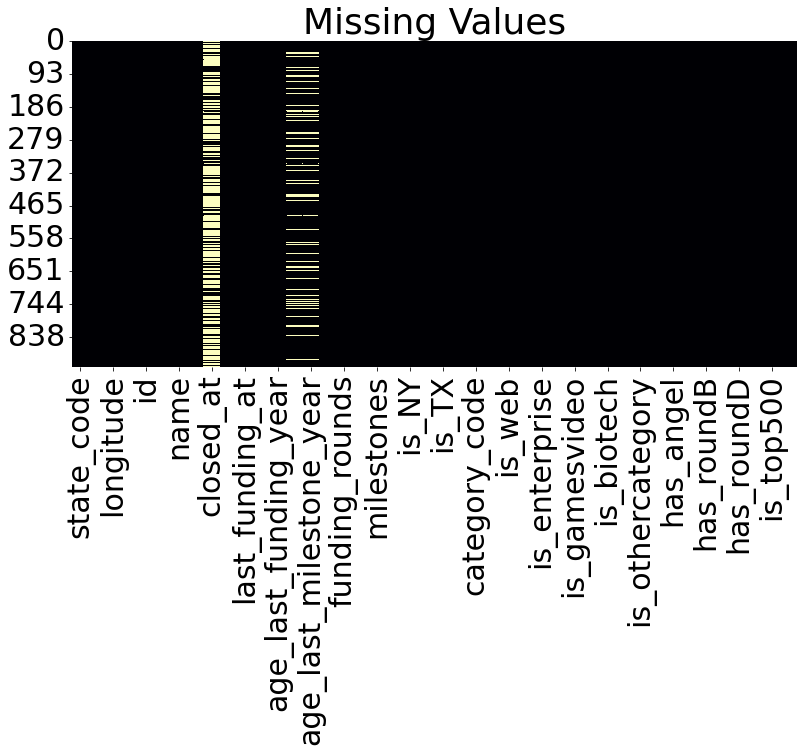

In [241]:
# Visualizing missing values
plt.figure(figsize=(13,6))
sns.heatmap(df.isnull(), cmap='magma', cbar=False)
plt.title('Missing Values')

**Columns: ```'age_first_milestone_year','age_last_milestone_year'```**

In [242]:
df[df['age_first_milestone_year'].isnull() & df['age_last_milestone_year'].isnull()].shape[0]

152

In [243]:
df[df['age_first_milestone_year'].isnull() & df['age_last_milestone_year'].isnull()]['milestones'].value_counts()

0    152
Name: milestones, dtype: int64

- ```'closed_at'``` column has 587 missing values since all of them were acquired and considered successful.
- ```'age_first_milestone_year'``` and ```'age_last_milestone_year'``` column has 152 missing values, all of which from the same rows. Moreover, the startups missing these two values all have 0 as a value in ```milestone``` column, indicating that they have no milestones.
- Therefore, we will impute value 0 to all NaN, and create another column indicating whether the number of milestone is zero.

In [244]:
def check_null(x):
    if np.isnan(x):
        return 1
    return 0

In [245]:
df['milestone_none'] = df['age_first_milestone_year'].apply(check_null)
df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(0)
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(0)

**Unique values in each column**

In [246]:
df.nunique()

state_code                   35
latitude                    651
longitude                   650
zip_code                    382
id                          922
city                        216
name                        922
founded_at                  217
closed_at                   202
first_funding_at            585
last_funding_at             680
age_first_funding_year      634
age_last_funding_year       756
age_first_milestone_year    471
age_last_milestone_year     585
relationships                41
funding_rounds                9
funding_total_usd           505
milestones                    8
is_CA                         2
is_NY                         2
is_MA                         2
is_TX                         2
is_otherstate                 2
category_code                35
is_software                   2
is_web                        2
is_mobile                     2
is_enterprise                 2
is_advertising                2
is_gamesvideo                 2
is_ecomm

- There are a number of binary categorical features in this dataset indicating the following:
 - States: ```is_CA,is_NY,is_MA,is_TX,is_otherstate```
 - Industry verticals: ```is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,
is_othercategory```
 - Investors: ```has_VC,has_angel```
 - Funding rounds: ```has_roundA,has_roundB,has_roundC,has_roundD```

# Feature Engineering

## Target Variables

We will perform binary classification using our ML algorithms to predict whether the company succeeded (acquired) or failed (closed). Therefore, we will encode the ```status``` column as follows:
- **1:** the startup was acquired (success)
- **0:** the startup was closed (failure)

In [247]:
# Encode success into indicator (1 = acquired, 0 = closed)
def encode_success(x):
    if x=='acquired':
        return 1
    else:
        return 0

df['success'] = df['status'].apply(encode_success)

In [248]:
df['success'].value_counts()

1    596
0    326
Name: success, dtype: int64

In [249]:
y = 'success'

## Features

In [250]:
df.columns

Index(['state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name',
       'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
       'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB',
       'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'status',
       'milestone_none', 'success'],
      dtype='object')

### Location
- These indicators which we will be using already existed in the dataset: ```'is_CA', 'is_NY', 'is_MA', 'is_TX'```
- We will create ```'is_WA'``` column as an indicator of whether the startup is in Washington state since WA is also the top 5 states for startups.
- We will not use ```'is_otherstate'``` column because of the collinearity problem. 
- We will not use state code or zip code since our data is limited.

In [251]:
def is_wa(x):
    if x == 'WA':
        return 1
    return 0

df['is_WA'] = df['state_code'].apply(is_wa)

## Other Variables
- We selected columns that are numerical or can be transformed to numerical variables.
- We decided to make changes to indicator variables for industry verticals by adding three more popular industry verticals ```'is_semiconductor', 'is_network_hosting', 'is_hardware'``` and not using ```is_othercategory``` due to the collinearity problem.

In [252]:
# After exploring industry vertical columns, we decided to drop is_consulting column since there are only 3 firms (rows) that are consulting firms.
df = df.drop(columns=['is_consulting'])

In [253]:
# We will add three indicator columns for semiconductor, network_hosting, and hardware.
def indicator(x, text):
    if x==text:
        return 1
    else:
        return 0

df['is_semiconductor'] = df['category_code'].apply(lambda x: indicator(x, 'semiconductor'))
df['is_network_hosting'] = df['category_code'].apply(lambda x: indicator(x, 'network_hosting'))
df['is_hardware'] = df['category_code'].apply(lambda x: indicator(x, 'hardware'))

In [254]:
X = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_WA',
       'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'milestone_none', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_semiconductor', 'is_network_hosting', 'is_hardware',
       'has_VC', 'has_angel', 'has_roundA', 'has_roundB',
       'has_roundC', 'has_roundD', 'avg_participants']

## Summary of Features and Targets

In [255]:
X

['is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_WA',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'milestone_none',
 'relationships',
 'funding_rounds',
 'funding_total_usd',
 'milestones',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_semiconductor',
 'is_network_hosting',
 'is_hardware',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundC',
 'has_roundD',
 'avg_participants']

In [256]:
print(f"The number of features: {len(X)}")

The number of features: 32


In [257]:
y

'success'

In [258]:
selected_col = X + [y]
selected_col

['is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_WA',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'milestone_none',
 'relationships',
 'funding_rounds',
 'funding_total_usd',
 'milestones',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_semiconductor',
 'is_network_hosting',
 'is_hardware',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundC',
 'has_roundD',
 'avg_participants',
 'success']

## Train-Test Split

In [259]:
# train size
train_size = 0.8
df_train = df.sample(frac=train_size,replace=False,random_state=8)

# test data
test_inds = set(df.index) - set(df_train.index)
df_test = df.loc[test_inds]

In [260]:
df_train.columns

Index(['state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name',
       'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
       'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_othercategory',
       'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC',
       'has_roundD', 'avg_participants', 'is_top500', 'status',
       'milestone_none', 'success', 'is_WA', 'is_semiconductor',
       'is_network_hosting', 'is_hardware'],
      dtype='object')

In [261]:
# train sample summary stats
tr = (
    pd
    .concat((df_train.mean(), df_train.std(), df_train.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te = (
    pd
    .concat((df_test.mean(), df_test.std(), df_test.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte = (
    pd
    .concat((tr,te),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / (x.tr_se**2 + x.te_se**2)**0.5)
    .loc[:,['tr_avg','te_avg','tdiff']]
)

trte

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,tr_avg,te_avg,tdiff
latitude,38.43,38.56,-0.39
longitude,-103.71,-104.64,0.52
age_first_funding_year,2.22,2.29,-0.39
age_last_funding_year,4.00,3.67,1.52
age_first_milestone_year,2.60,2.36,0.98
age_last_milestone_year,4.03,3.72,1.20
relationships,7.66,7.89,-0.37
funding_rounds,2.36,2.11,2.33
funding_total_usd,27342191.74,17661091.89,1.20
milestones,1.85,1.82,0.24


In [262]:
# Summary statistics
df_train.describe([.01,.5,.99]).T

,count,mean,std,min,1%,50%,99%,max
latitude,738.00,38.43,3.47,26.05,30.27,37.78,47.63,47.80
longitude,738.00,-103.71,21.36,-122.76,-122.58,-118.32,-71.06,-70.14
age_first_funding_year,738.00,2.22,2.60,-9.05,-1.00,1.42,10.83,21.90
age_last_funding_year,738.00,4.00,3.07,-9.05,-0.06,3.47,12.39,21.90
age_first_milestone_year,738.00,2.60,2.94,-7.01,-1.85,2.00,11.01,24.68
age_last_milestone_year,738.00,4.03,3.51,-7.01,-0.57,3.86,12.86,24.68
relationships,738.00,7.66,7.19,0.00,0.00,5.00,32.63,63.00
funding_rounds,738.00,2.36,1.42,1.00,1.00,2.00,7.00,10.00
funding_total_usd,738.00,27342191.74,211541827.30,11000.00,20439.93,10000000.00,137440546.61,5700000000.00
milestones,738.00,1.85,1.33,0.00,0.00,2.00,5.00,8.00


In [263]:
# Means by outcome
df_train.groupby('success').mean()

,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,milestone_none,is_WA,is_semiconductor,is_network_hosting,is_hardware
success,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,38.12,-102.66,2.56,3.80,1.65,2.38,4.24,1.99,16601135.43,1.22,0.48,0.08,0.05,0.06,0.32,0.17,0.15,0.08,0.05,0.05,0.08,0.03,0.04,0.35,0.38,0.29,0.37,0.28,0.14,0.05,2.40,0.64,0.33,0.05,0.03,0.03,0.05
1,38.61,-104.31,2.03,4.11,3.14,4.97,9.58,2.57,33395414.15,2.20,0.56,0.14,0.12,0.03,0.16,0.16,0.16,0.09,0.10,0.08,0.05,0.01,0.04,0.30,0.30,0.24,0.60,0.47,0.28,0.13,3.11,0.90,0.07,0.03,0.03,0.04,0.02


# Exploratory Data Analysis (EDA)
- Exploratory Data Analysis (EDA) is an analyzing approach that summarizes the main characteristics of a given dataset.
- After cleaning and inspecting data of US-based startups operating between 2005 and 2012, we will perform an exploratory data analysis (EDA) by taking a deep look at the following features:

 - Location/Geography (state/zip code/city)
 - Founding date and closing date (if any)
 - First funding date and last funding date
 - Age when the startup received its first funding and last funding
 - The number of milestones and age at the first and last milestones
 - The number of relationships that the startup has
 - The number of funding rounds (A/B/C/D)
 - Total funding amount
 - Industry types or verticals
 - VC-backed status
 - Angel investor status
 - The number of participants in the startup

- We will look at each feature separately and integrate our domain knowledge into the analysis and visualization. Additionally, we will identify interesting trends or correlations between the features to gain more insights into the dataset.

- Note that our data is limited. Thus, EDA of training data might not capture the whole pictures.

## Data Exploration & Visualization
We will take a closer look into the dataset by looking at each feature and integrate our domain knowledge into the analysis and visualization.

In [264]:
df_train['success'].sum()

472

In [265]:
df_train[df_train['success'] == 0].count()

state_code                  266
latitude                    266
longitude                   266
zip_code                    266
id                          266
city                        266
name                        266
founded_at                  266
closed_at                   266
first_funding_at            266
last_funding_at             266
age_first_funding_year      266
age_last_funding_year       266
age_first_milestone_year    266
age_last_milestone_year     266
relationships               266
funding_rounds              266
funding_total_usd           266
milestones                  266
is_CA                       266
is_NY                       266
is_MA                       266
is_TX                       266
is_otherstate               266
category_code               266
is_software                 266
is_web                      266
is_mobile                   266
is_enterprise               266
is_advertising              266
is_gamesvideo               266
is_ecomm

In [266]:
len(df_train['success'])

738

## Location and Geography
- Relevant columns:
 - ```'state_code'```
 - ```'latitude'```
 - ```'longitude'```
 - ```'zip_code'```
 - ```'city'```
- First, we will find the top locations that startups operated between 2005-2012.

In [267]:
# Top 10 States of Startup Location
pd.DataFrame(df_train['state_code'].value_counts())[:10].rename(columns={'state_code':'frequency'})

,frequency
CA,391
NY,85
MA,69
TX,31
WA,29
IL,17
PA,17
CO,15
VA,8
GA,8


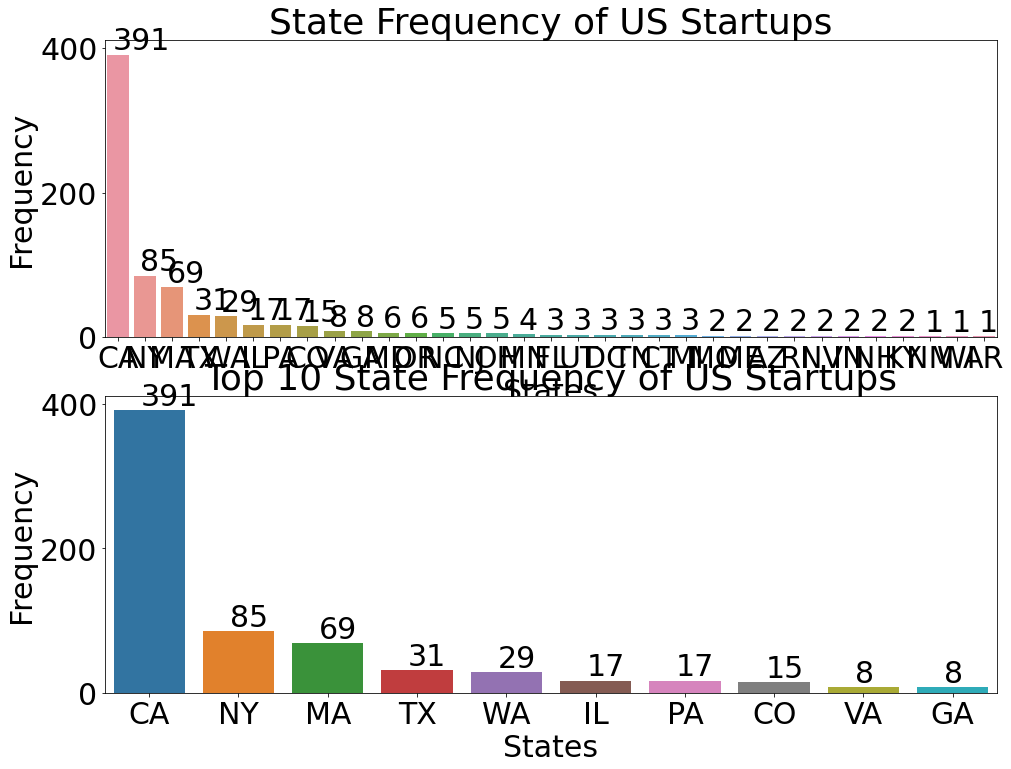

In [268]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
# fig.suptitle('Location (States) of US Startups', fontsize=20)

sns.countplot(ax=ax[0], data = df_train, x = 'state_code', order = df_train['state_code'].value_counts().index)
ax[0].set_xlabel('States')
ax[0].set_ylabel('Frequency')
ax[0].set_title('State Frequency of US Startups')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+7))

sns.barplot(ax=ax[1], x = pd.DataFrame(df_train['state_code'].value_counts())[:10].index, y=pd.DataFrame(df_train['state_code'].value_counts())[:10]['state_code'])
ax[1].set_xlabel('States')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Top 10 State Frequency of US Startups')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+7))


In [269]:
# List of top 5 states
top_5_states = ['CA','NY','MA','TX','WA']

In [270]:
fig = px.scatter_geo(df_train,lat='latitude',lon='longitude')
fig.update_layout(title = 'US Startup Location, 2005-2012', title_x=0.5)
fig.show()

In [271]:
# pk.eyJ1Ijoibmlja3lrYW50YXBob24iLCJhIjoiY2w5cTAycWFhMG94aDN1bGIyMTFzanV4eiJ9.FU2uNAKwQm8oVlsXl9T_iA
# Create "mapbox_token" file and paste the above token to "mapbox_token"

px.set_mapbox_access_token(open("mapbox_token").read())
px.scatter_mapbox(df_train, lat="latitude", lon="longitude", color="status", size="funding_total_usd", hover_data=["name"], color_continuous_scale=px.colors.cyclical.IceFire, zoom=3)

In [272]:
found_location_df_train = df_train[['founded_at','state_code','city']]
found_location_df_train['founded_date'] = found_location_df_train['founded_at'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
found_location_df_train['year'] = found_location_df_train['founded_date'].apply(lambda x: x.year)
found_location_df_train = found_location_df_train.groupby(by=['year','state_code']).agg(
    count = pd.NamedAgg(column = 'founded_at', aggfunc='count')).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Number of Startups Founded in Top 5 States')

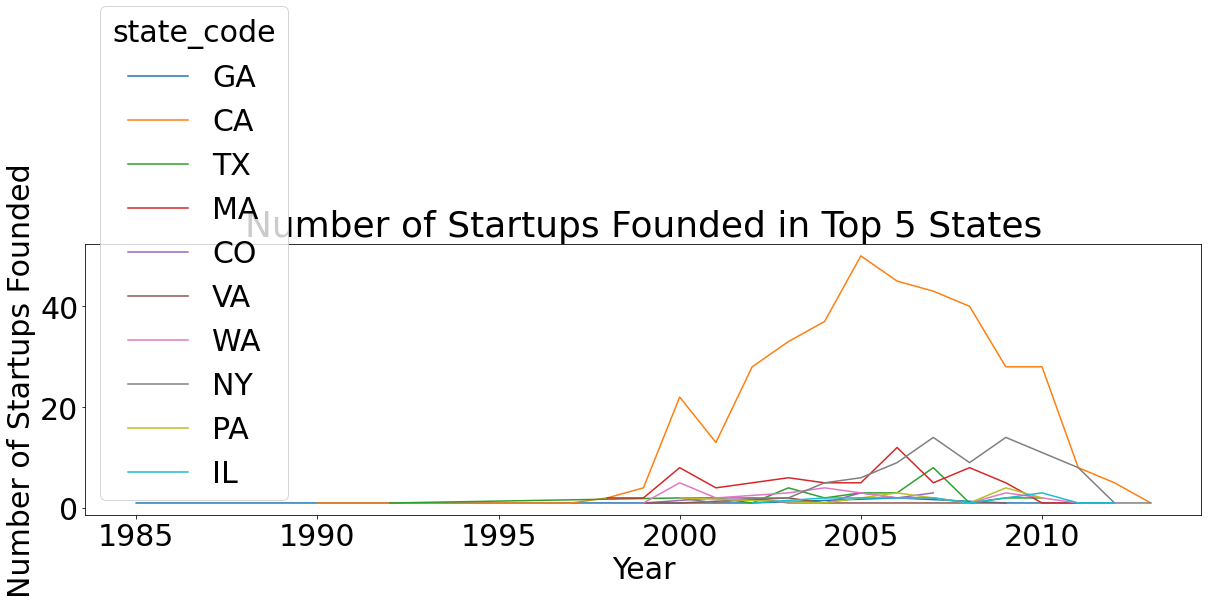

In [273]:
plt.figure(figsize=(20,5))
sns.lineplot(data=found_location_df_train[found_location_df_train['state_code'].isin(['CA','NY','MA','TX','WA','CO','IL','PA','VA','GA'])], x='year', y="count", hue="state_code")
plt.ylabel('Number of Startups Founded')
plt.xlabel('Year')
plt.title('Number of Startups Founded in Top 5 States')

In [274]:
state_df_train = df_train[['state_code','status']].groupby('state_code').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
).sort_values(by='total',ascending=False)
# Source for .agg function: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [275]:
# Top 10 states US startups operated from 2005-2012
state_df_train.head(10)

,success,failure,total,pct_success,pct_failure
state_code,,,,,
CA,263,128,391,67.26,32.74
NY,64,21,85,75.29,24.71
MA,55,14,69,79.71,20.29
TX,14,17,31,45.16,54.84
WA,16,13,29,55.17,44.83
IL,8,9,17,47.06,52.94
PA,6,11,17,35.29,64.71
CO,11,4,15,73.33,26.67
VA,4,4,8,50.00,50.00


In [276]:
fig = px.choropleth(state_df_train.reset_index(),
                    locations='state_code', 
                    locationmode="USA-states", 
                    color='total',
                    color_continuous_scale="viridis_r", 
                    scope="usa",
                    labels={'total':'Total'},
                    title = 'Number of Startups by States (2005-2012)'
                    )
fig.show()

In [277]:
city_df_train = df_train[['city','status']].groupby('city').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
).sort_values(by='total',ascending=False)

In [278]:
# Top 20 cities US startups operated from 2005-2012
city_df_train.head(20)

,success,failure,total,pct_success,pct_failure
city,,,,,
San Francisco,72,23,95,75.79,24.21
New York,59,19,78,75.64,24.36
Mountain View,27,12,39,69.23,30.77
Palo Alto,18,8,26,69.23,30.77
Sunnyvale,17,6,23,73.91,26.09
San Mateo,15,7,22,68.18,31.82
Santa Clara,12,9,21,57.14,42.86
Austin,11,9,20,55.00,45.00
Seattle,9,7,16,56.25,43.75


- As expected, startups are predominantly located in a few places, with the majority in California (487). The number of startups in CA is almost 5 times greater than the runner-up New York (106). Massachusetts (83) and Texas (42) came in next. These states have big startup hubs such as San Francisco, Silicon Valley, New York City, Austin, etc.
- Now, we will look at the relationship between success and location of startups.

In [279]:
state_df_train.sort_values(by='success',ascending=False).head(10)

,success,failure,total,pct_success,pct_failure
state_code,,,,,
CA,263,128,391,67.26,32.74
NY,64,21,85,75.29,24.71
MA,55,14,69,79.71,20.29
WA,16,13,29,55.17,44.83
TX,14,17,31,45.16,54.84
CO,11,4,15,73.33,26.67
IL,8,9,17,47.06,52.94
PA,6,11,17,35.29,64.71
OR,5,1,6,83.33,16.67


In [280]:
fig = px.choropleth(state_df_train.reset_index(),
                    locations='state_code', 
                    locationmode="USA-states", 
                    color='success',
                    color_continuous_scale="viridis_r", 
                    scope="usa",
                    labels={'success':'Total'},
                    title = 'Number of Success Startups by States (2005-2012)'
                    )
fig.show()

- The number of success startups is consistent with the total number of startups in each state.
- Top states are CA, NY, MA, WA, and TX.

In [281]:
# overall success rate (%)
(state_df_train['success'].sum(axis=0) / state_df_train['total'].sum(axis=0))*100

63.956639566395665

In [282]:
# Success rate of startups in the states with more than 10 startups
state_df_train[state_df_train['total']>=10].sort_values(by='pct_success',ascending=False)

,success,failure,total,pct_success,pct_failure
state_code,,,,,
MA,55,14,69,79.71,20.29
NY,64,21,85,75.29,24.71
CO,11,4,15,73.33,26.67
CA,263,128,391,67.26,32.74
WA,16,13,29,55.17,44.83
IL,8,9,17,47.06,52.94
TX,14,17,31,45.16,54.84
PA,6,11,17,35.29,64.71


In [283]:
fig = px.choropleth(state_df_train.reset_index(),
                    locations='state_code', 
                    locationmode="USA-states", 
                    color='pct_success',
                    color_continuous_scale="viridis_r", 
                    scope="usa",
                    labels={'pct_success':'Percentage (%)'},
                    title = 'Percentage of Startup Success by States (2005-2012)'
                    )
fig.show()

- We filter out states with lower than 10 startups to ensure the big enough sample size and meaningful result from percentages
- Massachusetts has the highest success rate of 79.7%. The other top 4 are New York (75.3%), Colorado (73.3%), California (67.3%), and Washington (55.2%)
- Overall, states with high number of startups also have relatively higher success rates than average of 64.0%. Note that California dominates the dataset.

In [284]:
# Success rate of startups in the cities with more than 10 startups
city_df_train[city_df_train['total']>=10].sort_values(by='pct_success',ascending=False)

,success,failure,total,pct_success,pct_failure
city,,,,,
Cambridge,13,1,14,92.86,7.14
Boston,11,2,13,84.62,15.38
San Francisco,72,23,95,75.79,24.21
New York,59,19,78,75.64,24.36
Sunnyvale,17,6,23,73.91,26.09
Redwood City,8,3,11,72.73,27.27
Palo Alto,18,8,26,69.23,30.77
Mountain View,27,12,39,69.23,30.77
San Mateo,15,7,22,68.18,31.82


- The cities with highest success rates of startups are mostly in the San Francisco Bay Area and Silicon Valley as well as some other cities like Cambridge, Boston, New York, and Austin.

### Location and other relevant variables
- Total funding amount
- VC-backed status
- Angel investor status
- The number of participants in the startup


In [285]:
# By states: funding amount (total and average), percentage of startups with VCs and angel investors
location_funding_df_train = df_train.groupby('state_code').agg(
    count = pd.NamedAgg(column = 'funding_total_usd', aggfunc='count'),
    total_funding_amt_mn = pd.NamedAgg(column = 'funding_total_usd', aggfunc='sum'),
    avg_funding_amt_mn = pd.NamedAgg(column = 'funding_total_usd', aggfunc='mean'),
    med_funding_amt_mn = pd.NamedAgg(column = 'funding_total_usd', aggfunc='median'),
    pct_vc_backed = pd.NamedAgg(column = 'has_VC',aggfunc=(lambda x: np.mean(x)*100)),
    pct_angel_backed = pd.NamedAgg(column = 'has_angel',aggfunc=(lambda x: np.mean(x)*100)),
    avg_participants = pd.NamedAgg(column = 'avg_participants',aggfunc='mean')
).sort_values(by='total_funding_amt_mn',ascending=False)
location_funding_df_train[['total_funding_amt_mn','avg_funding_amt_mn','med_funding_amt_mn']] = location_funding_df_train[['total_funding_amt_mn','avg_funding_amt_mn','med_funding_amt_mn']].applymap(lambda x: x/1000000)

location_funding_df_train

,count,total_funding_amt_mn,avg_funding_amt_mn,med_funding_amt_mn,pct_vc_backed,pct_angel_backed,avg_participants
state_code,,,,,,,
CA,391,8286.03,21.19,11.04,29.41,22.51,2.97
WA,29,6174.27,212.91,10.00,31.03,24.14,2.93
MA,69,1490.13,21.60,16.10,39.13,15.94,2.80
NY,85,1073.79,12.63,4.71,24.71,48.24,3.28
CO,15,767.22,51.15,13.25,60.00,20.00,2.80
TX,31,449.26,14.49,9.20,35.48,12.90,2.49
PA,17,245.75,14.46,3.51,52.94,41.18,1.85
IN,2,240.40,120.20,120.20,100.00,0.00,2.50
NC,5,211.12,42.22,8.00,40.00,20.00,4.70


In [286]:
location_funding_df_train.corr()

,count,total_funding_amt_mn,avg_funding_amt_mn,med_funding_amt_mn,pct_vc_backed,pct_angel_backed,avg_participants
count,1.00,0.83,0.03,-0.02,-0.05,-0.05,0.06
total_funding_amt_mn,0.83,1.00,0.51,0.01,-0.04,-0.08,0.07
avg_funding_amt_mn,0.03,0.51,1.00,0.47,0.17,-0.19,0.09
med_funding_amt_mn,-0.02,0.01,0.47,1.00,0.42,-0.29,0.08
pct_vc_backed,-0.05,-0.04,0.17,0.42,1.00,-0.17,-0.32
pct_angel_backed,-0.05,-0.08,-0.19,-0.29,-0.17,1.00,-0.31
avg_participants,0.06,0.07,0.09,0.08,-0.32,-0.31,1.00


In [287]:
c0 = location_funding_df_train['total_funding_amt_mn'].corr(location_funding_df_train['count'])
c1 = location_funding_df_train['total_funding_amt_mn'].corr(location_funding_df_train['avg_funding_amt_mn'])
c2 = location_funding_df_train['avg_funding_amt_mn'].corr(location_funding_df_train['count'])

Text(340, 175, 'Corr: 0.03')

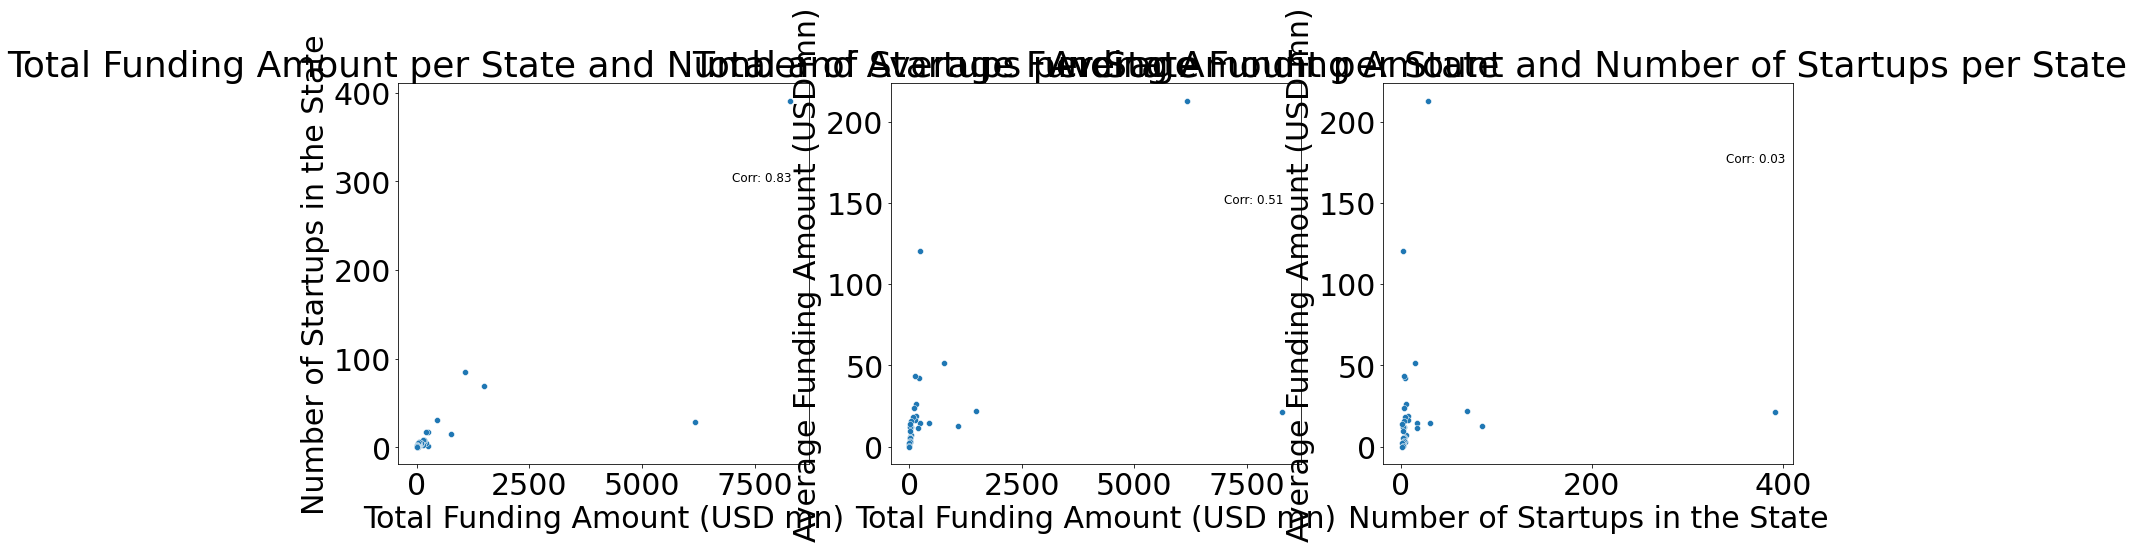

In [288]:
# Total amount of funding and average funding amount
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

sns.scatterplot(ax=ax[0], x=location_funding_df_train['total_funding_amt_mn'], y=location_funding_df_train['count'])
ax[0].set_ylabel('Number of Startups in the State')
ax[0].set_xlabel('Total Funding Amount (USD mn)')
ax[0].set_title('Total Funding Amount per State and Number of Startups per State')
ax[0].text(7000, 300, f'Corr: {round(c0,2)}',fontsize=12)

sns.scatterplot(ax=ax[1], x=location_funding_df_train['total_funding_amt_mn'], y=location_funding_df_train['avg_funding_amt_mn'])
ax[1].set_ylabel('Average Funding Amount (USD mn)')
ax[1].set_xlabel('Total Funding Amount (USD mn)')
ax[1].set_title('Total and Average Funding Amount per State')
ax[1].text(7000, 150, f'Corr: {round(c1,2)}',fontsize=12)


sns.scatterplot(ax=ax[2], x=location_funding_df_train['count'], y=location_funding_df_train['avg_funding_amt_mn'])
ax[2].set_ylabel('Average Funding Amount (USD mn)')
ax[2].set_xlabel('Number of Startups in the State')
ax[2].set_title('Average Funding Amount and Number of Startups per State')
ax[2].text(340, 175, f'Corr: {round(c2,2)}',fontsize=12)

- There is a very strong correlation (83%) between the total funding and the number of startups in the state. In other words, The top states with the most startups are very likely to have the highest amount of total fundings.
- However, there is almost no correlation (3%) between the average funding and the number of startups in the state but there is some correlation (51%) between the total funding and the average funding per firm. Being in a state with historically high funding could contribute to the higher funding for a startup.
- The percentages of startups having VCs and angel investors, and the number of participants in the firm also have close-to-zero correlation with the number of startups in the state.

### Analysis of Top 5 States

In [289]:
top_5_states

['CA', 'NY', 'MA', 'TX', 'WA']

#### California
- City & regions
- Industry verticals

In [290]:
# Top 15 cities in California with highest number of startups
cali_df_train = df_train[df_train['state_code']=='CA']
cali_city_count_df_train = cali_df_train.groupby('city').agg(
    num_startups = pd.NamedAgg(column = 'id',aggfunc='count'),
).sort_values(by='num_startups', ascending=False)
cali_city_count_df_train.head(15)

,num_startups
city,
San Francisco,95
Mountain View,39
Palo Alto,26
Sunnyvale,23
San Mateo,22
Santa Clara,21
Menlo Park,14
San Diego,13
San Jose,13


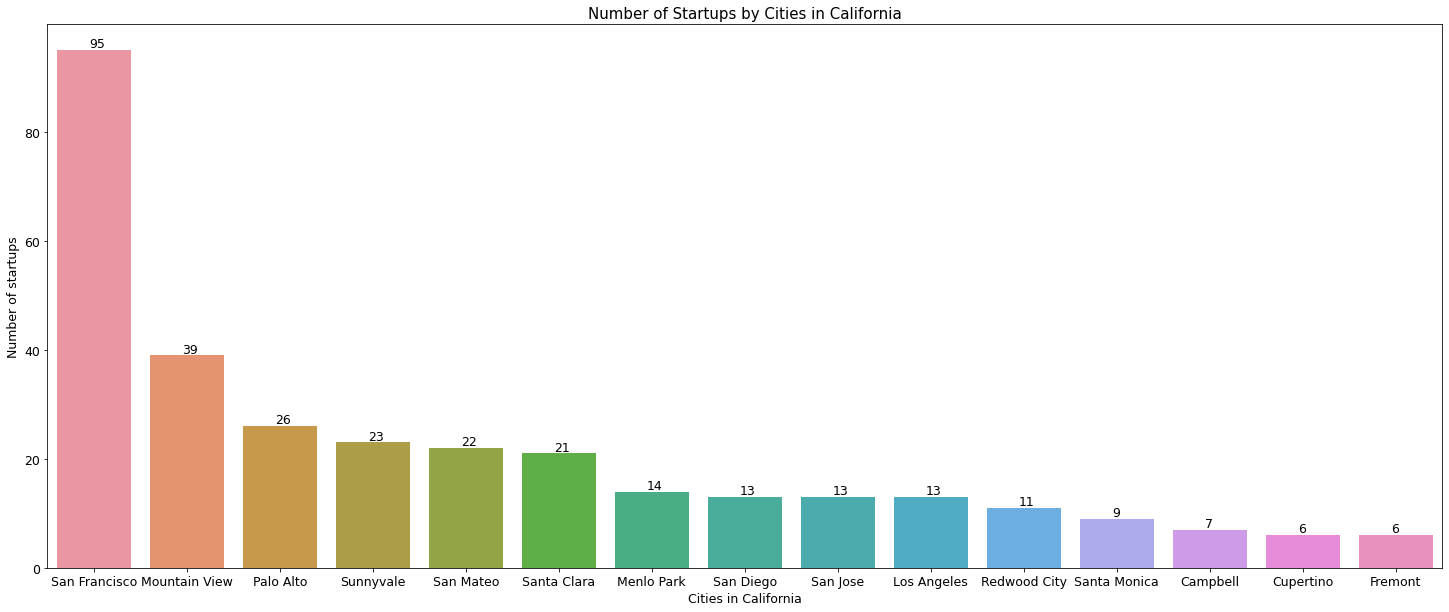

In [291]:
plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=cali_city_count_df_train[:15].index, y=cali_city_count_df_train[:15]['num_startups'])
plt.xlabel('Cities in California')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Cities in California')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- We can see that San Francisco had the highest number of startups, higher than the runner-up by a big margin.
- The majority of top 15 cities are in San Francisco Bay Area and Silicon Valley such as Mountain View, Palo Alto, Santa Clara, Sunnyvale, San Jose, etc.
- The only big hubs outside of the Bay Area include San Diego and Los Angeles.

In [292]:
cali_category_df_train = cali_df_train.groupby('category_code').agg(count = pd.NamedAgg(column = 'id', aggfunc='count')).sort_values(by='count',ascending=False)
cali_category_df_train.head(15)

,count
category_code,
web,61
software,60
mobile,32
enterprise,30
games_video,27
advertising,27
hardware,18
semiconductor,17
biotech,14


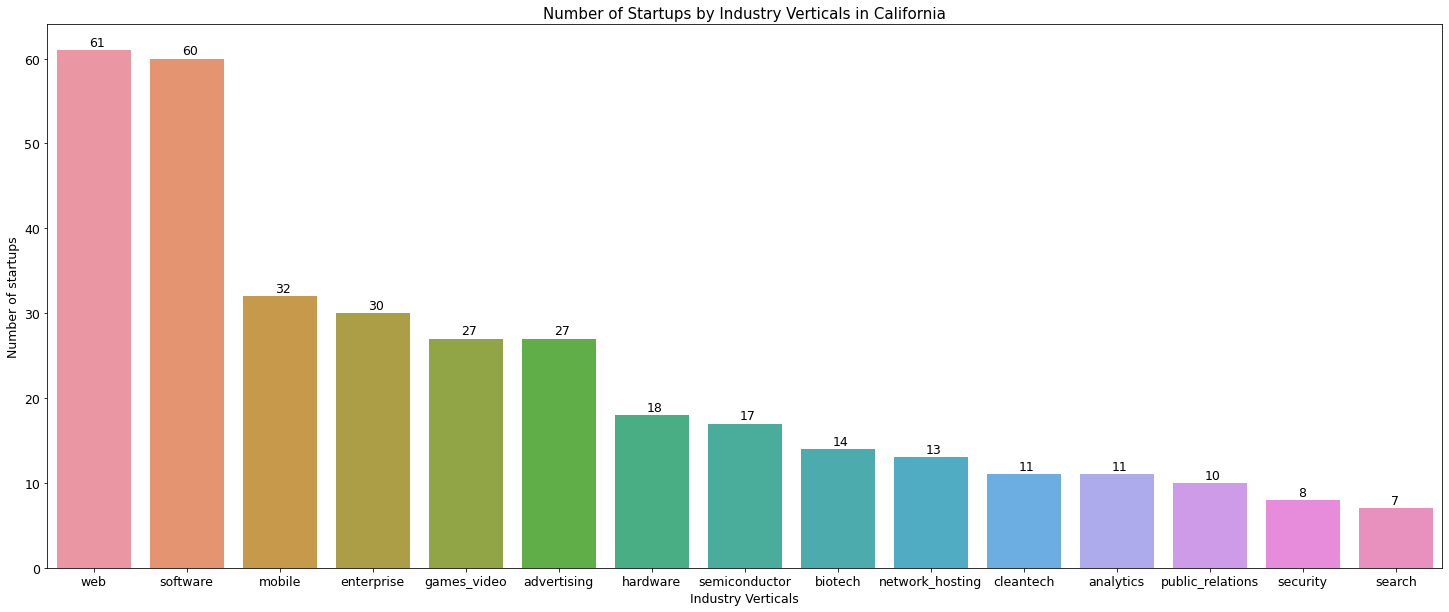

In [293]:
plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=cali_category_df_train[:15].index, y=cali_category_df_train[:15]['count'])
plt.xlabel('Industry Verticals')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Industry Verticals in California')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- The biggest industry vertical of startups in California is undeniably technology, with web and software the most popular types of tech startups.
- Other popular technology verticals that make the top 15 include mobile, enterprise, advertising, video games, semiconductor, biotech, and hardware.

#### Massachusetts
- City & regions
- Industry verticals

In [294]:
# Top 10 cities in Massachusetts with highest number of startups
ma_df_train = df_train[df_train['state_code']=='MA']
ma_city_count_df_train = ma_df_train.groupby('city').agg(
    num_startups = pd.NamedAgg(column = 'id',aggfunc='count'),
).sort_values(by='num_startups', ascending=False)
ma_city_count_df_train.head(10)

,num_startups
city,
Cambridge,14
Boston,13
Waltham,8
Burlington,8
Woburn,3
Boxborough,3
Lexington,2
Needham,2
Acton,2


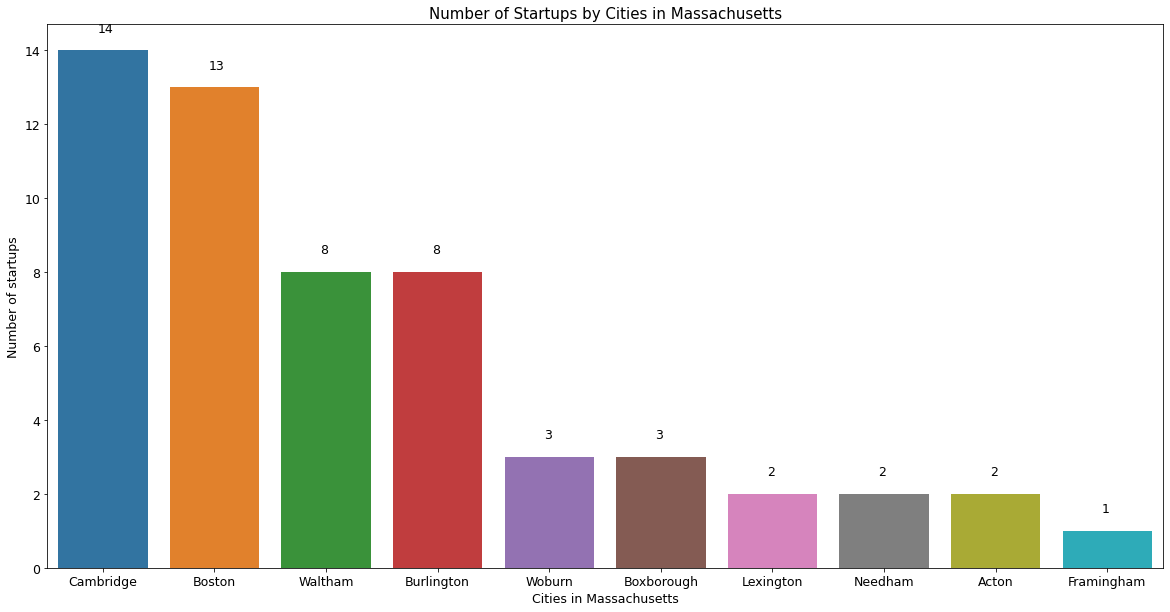

In [295]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=ma_city_count_df_train[:10].index, y=ma_city_count_df_train[:10]['num_startups'])
plt.xlabel('Cities in Massachusetts')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Cities in Massachusetts')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- Almost all of the cities in MA where startups were located are in Greater Boston Area.
- The city with highest number of startups is Cambridge, presumably from the fact that a lot of startups were founded from Harvard and MIT.
- Waltham and Burlington are also in the vicinity of Boston, making them popular sites for company's headquarters.


In [296]:
ma_category_df_train = ma_df_train.groupby('category_code').agg(count = pd.NamedAgg(column = 'id', aggfunc='count')).sort_values(by='count',ascending=False)
ma_category_df_train

,count
category_code,
software,20
web,10
mobile,8
advertising,5
biotech,5
enterprise,3
network_hosting,3
security,3
ecommerce,2


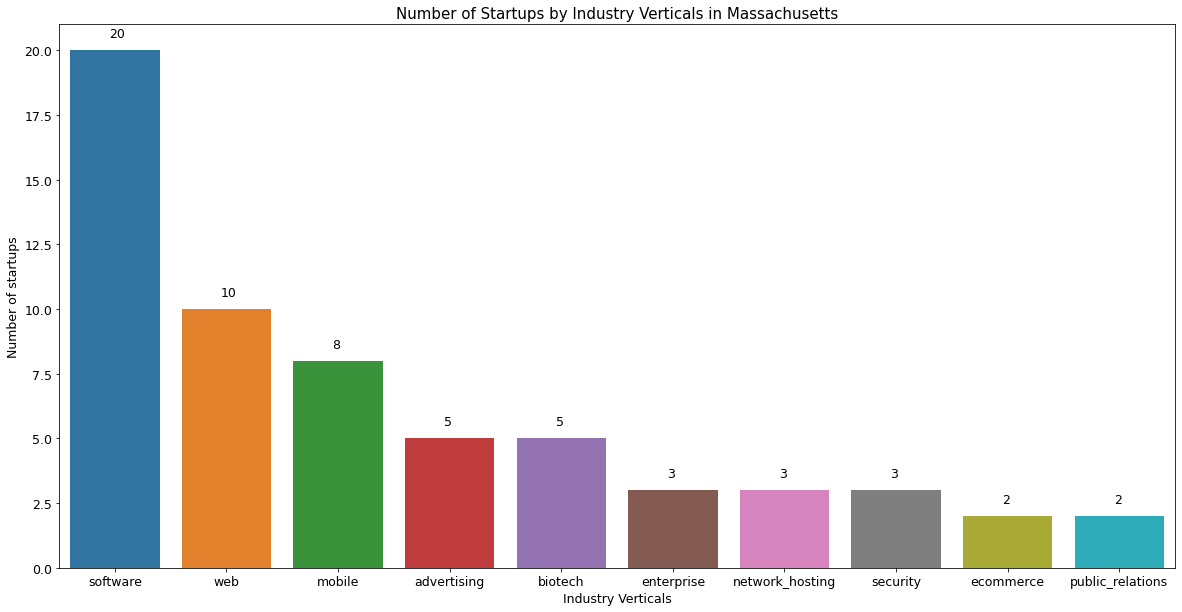

In [297]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=ma_category_df_train[:10].index, y=ma_category_df_train[:10]['count'])
plt.xlabel('Industry Verticals')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Industry Verticals in Massachusetts')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- Like CA, the biggest industry for MA startups is technology, with software at the top of the list, followed by web and mobile.

#### New York
- City & regions
- Industry verticals

In [298]:
# Cities in New York with highest number of startups
ny_df_train = df_train[df_train['state_code']=='NY']
ny_city_count_df_train = ny_df_train.groupby('city').agg(
    num_startups = pd.NamedAgg(column = 'id',aggfunc='count'),
).sort_values(by='num_startups', ascending=False)
ny_city_count_df_train

,num_startups
city,
New York,78
Brooklyn,4
Kenmore,1
Long Island City,1
Rye Brook,1


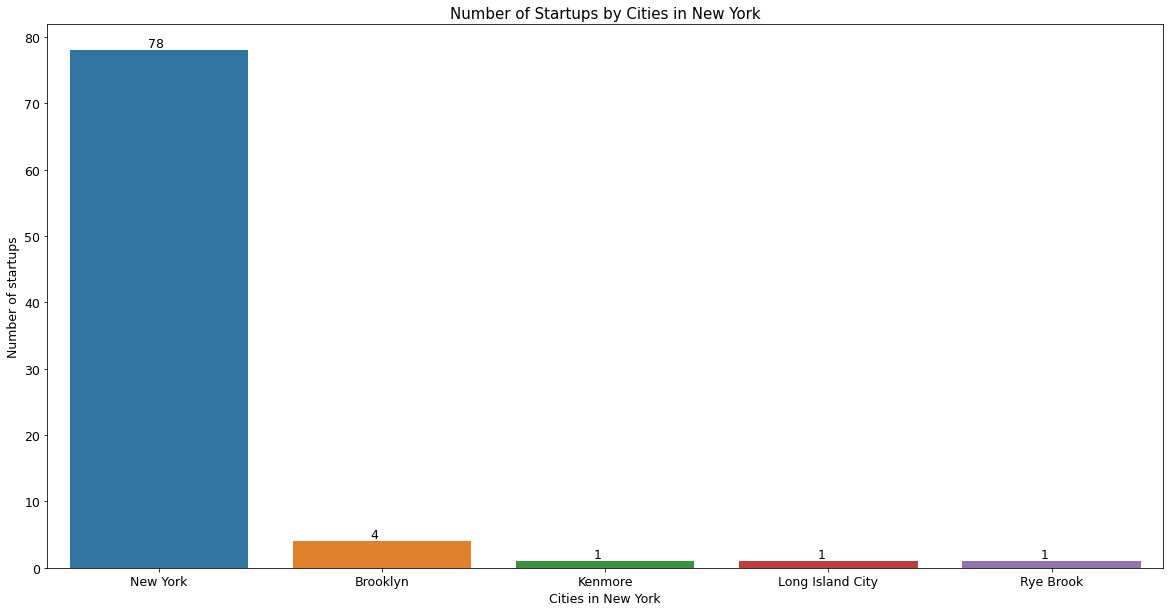

In [299]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=ny_city_count_df_train[:10].index, y=ny_city_count_df_train[:10]['num_startups'])
plt.xlabel('Cities in New York')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Cities in New York')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- Startups in New York are clustered within the New York City Metropolitan Area, with the huge majority of firms located in New York City, the financial hub of the world.

In [300]:
ny_category_df_train = ny_df_train.groupby('category_code').agg(count = pd.NamedAgg(column = 'id', aggfunc='count')).sort_values(by='count',ascending=False)
ny_category_df_train

,count
category_code,
web,18
games_video,12
advertising,9
mobile,6
software,5
social,5
enterprise,4
ecommerce,4
travel,3


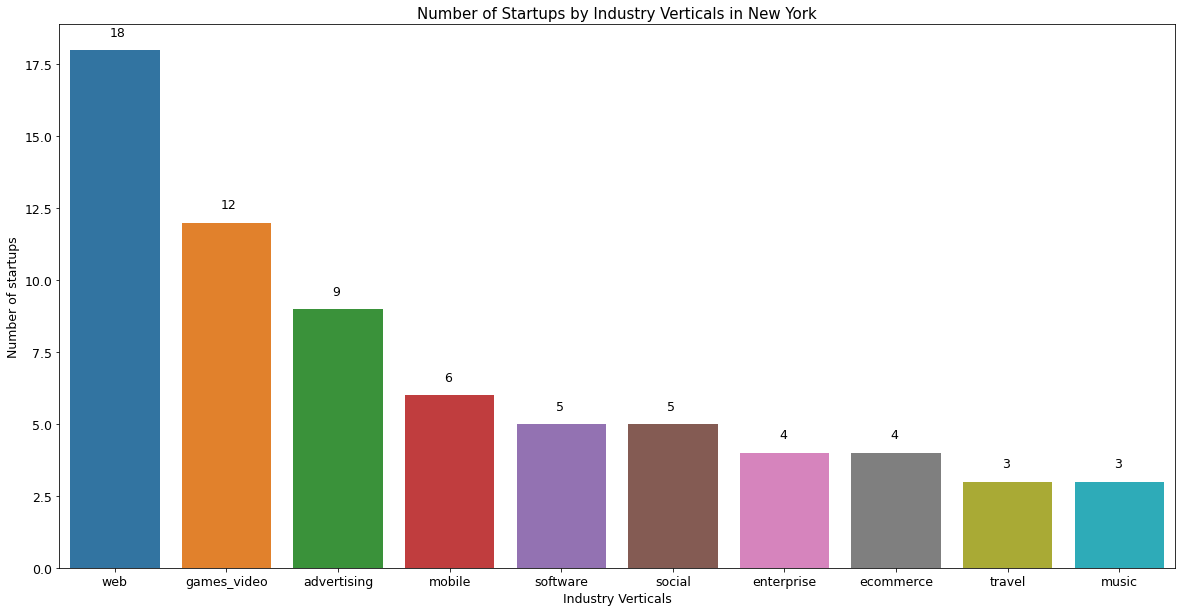

In [301]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=ny_category_df_train[:10].index, y=ny_category_df_train[:10]['count'])
plt.xlabel('Industry Verticals')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Industry Verticals in New York')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- We still see similar trends where technology industry dominates startups.
- Interestingly, software and mobile are falling behind verticals like video games and advertising.
- Since New York is naturally not a technology hub like Silicon Valley and has more diverse companies located here, other verticals like advertising, video games, social, e-commerce, and fashion make the top of the list.

#### Texas
- City & regions
- Industry verticals

In [302]:
# Cities in Texas with highest number of startups
tx_df_train = df_train[df_train['state_code']=='TX']
tx_city_count_df_train = tx_df_train.groupby('city').agg(
    num_startups = pd.NamedAgg(column = 'id',aggfunc='count'),
).sort_values(by='num_startups', ascending=False)
tx_city_count_df_train

,num_startups
city,
Austin,20
Addison,4
Richardson,2
Dallas,1
Houston,1
Plano,1
The Woodlands,1
Waco,1


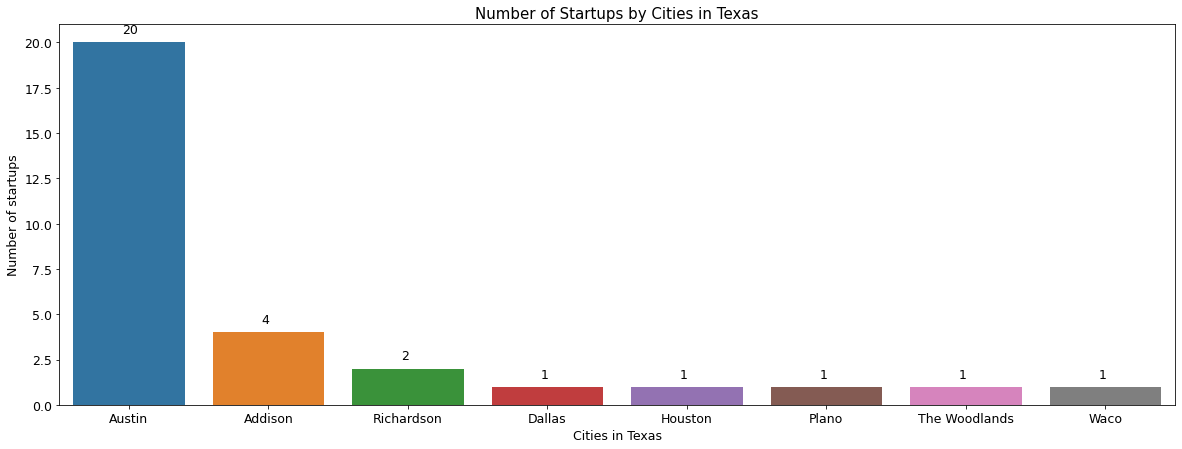

In [303]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=tx_city_count_df_train[:10].index, y=tx_city_count_df_train[:10]['num_startups'])
plt.xlabel('Cities in Texas')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Cities in Texas')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- Rising technology hub like Austin dominates the list. More startups are founded and operate in Austin, and more big tech companies moved their headquarters to Austin such as Oracle and Tesla.
- Texas is a very digitized state and ranks high in terms of employment specialization.
- Texas has the second highest growth in the working age population nationwide and large amount of spending on incentive programs.
- Austin in particular tends to have easier and better access to resources: more venture investment capital, higher education assets and a growing working-age population.

In [304]:
tx_category_df_train = tx_df_train.groupby('category_code').agg(count = pd.NamedAgg(column = 'id', aggfunc='count')).sort_values(by='count',ascending=False)
tx_category_df_train

,count
category_code,
software,7
enterprise,6
web,3
cleantech,2
mobile,2
security,2
semiconductor,2
consulting,1
games_video,1


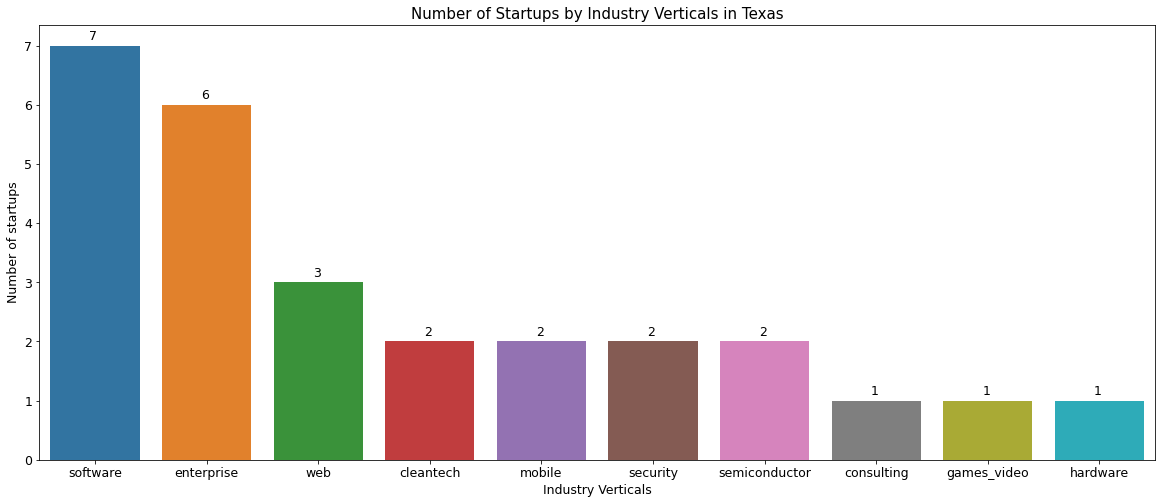

In [305]:
plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=tx_category_df_train[:10].index, y=tx_category_df_train[:10]['count'])
plt.xlabel('Industry Verticals')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Industry Verticals in Texas')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.1))

- Technology dominates the list, with software, enterprise, and web at the top 3 verticals.
- Semiconductor industry comes in the fourth place, highlighting the fact that Texas is a semiconductor hub of North America, with a lot of facilities and factories opened in the state.

#### Washington
- City & regions
- Industry verticals

In [306]:
# Cities in Washington with highest number of startups
wa_df_train = df_train[df_train['state_code']=='WA']
wa_city_count_df_train = wa_df_train.groupby('city').agg(
    num_startups = pd.NamedAgg(column = 'id',aggfunc='count'),
).sort_values(by='num_startups', ascending=False)
wa_city_count_df_train

,num_startups
city,
Seattle,16
Bellevue,5
Bothell,2
Kirkland,2
Redmond,2
Puyallup,1
Vancouver,1


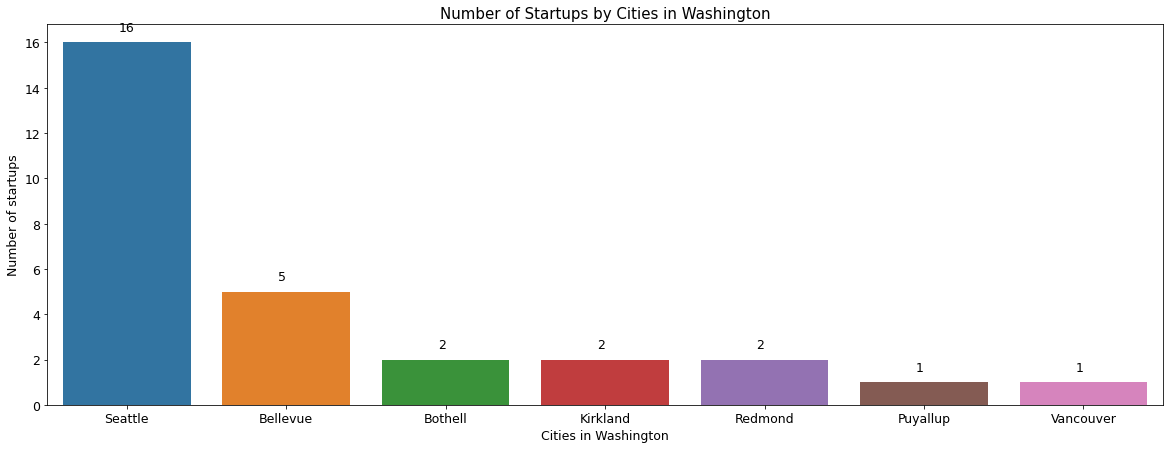

In [307]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=wa_city_count_df_train[:10].index, y=wa_city_count_df_train[:10]['num_startups'])
plt.xlabel('Cities in Washington')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Cities in Washington')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.5))

- The majority of startups are located in the Seattle Metropolitan Area, which is home to big tech companies like Amazon and Microsoft.

In [308]:
wa_category_df_train = wa_df_train.groupby('category_code').agg(count = pd.NamedAgg(column = 'id', aggfunc='count')).sort_values(by='count',ascending=False)
wa_category_df_train

,count
category_code,
enterprise,5
software,5
web,5
mobile,4
network_hosting,4
advertising,1
games_video,1
other,1
photo_video,1


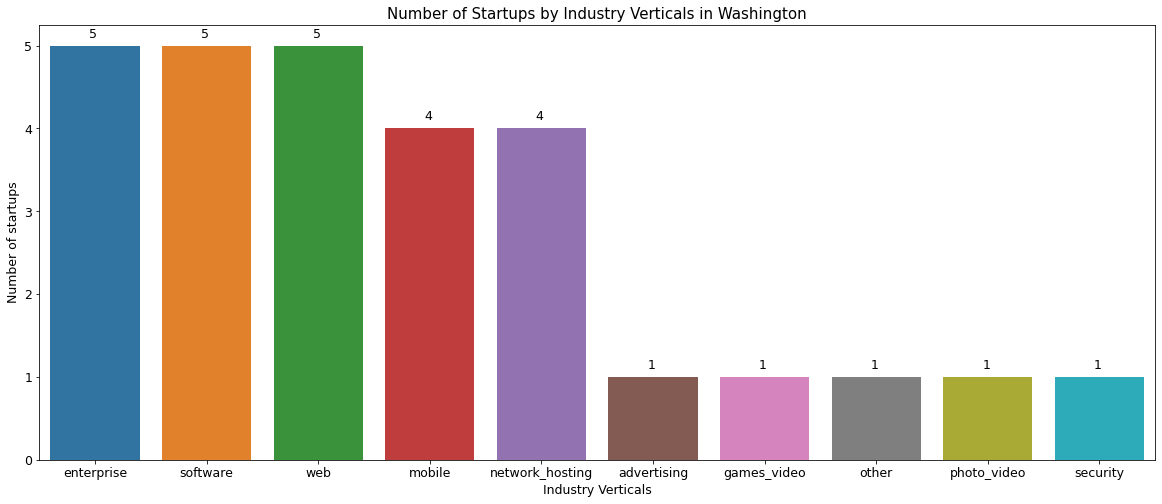

In [309]:
plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=wa_category_df_train[:10].index, y=wa_category_df_train[:10]['count'])
plt.xlabel('Industry Verticals')
plt.ylabel('Number of startups')
plt.title('Number of Startups by Industry Verticals in Washington')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.1))

- Technology companies again dominate the startup verticals, with software and web come at the top.
- Home to top CS school like University of Washington and big tech companies like Amazon and Microsoft, Seattle metropolitan area is undoubtedly another big technology hub of the US that attracts startups to operate.

## Founding Dates
- Relevant columns:
 - ```'founded_at'```

- We will group founding dates by year and explore the relationship with success rate.

In [310]:
# Change types of all dates to datetime 
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'], format="%m/%d/%Y")
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format="%m/%d/%Y")
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'], format="%m/%d/%Y")
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'], format="%m/%d/%Y")

In [311]:
# Get year
df_train['founded_year'] = df_train['founded_at'].apply(lambda x: x.year)
df_train['closed_year'] = df_train['closed_at'].apply(lambda x: x.year)
df_train['first_funding_year'] = df_train['first_funding_at'].apply(lambda x: x.year)
df_train['last_funding_year'] = df_train['last_funding_at'].apply(lambda x: x.year)

In [312]:
found_df_train = df_train[['founded_year','status']].groupby('founded_year').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
)
found_df_train.loc[2000:2011]

,success,failure,total,pct_success,pct_failure
founded_year,,,,,
2000,42,8,50,84.00,16.00
2001,21,8,29,72.41,27.59
2002,32,10,42,76.19,23.81
2003,39,15,54,72.22,27.78
2004,37,24,61,60.66,39.34
2005,58,24,82,70.73,29.27
2006,56,34,90,62.22,37.78
2007,56,29,85,65.88,34.12
2008,41,23,64,64.06,35.94


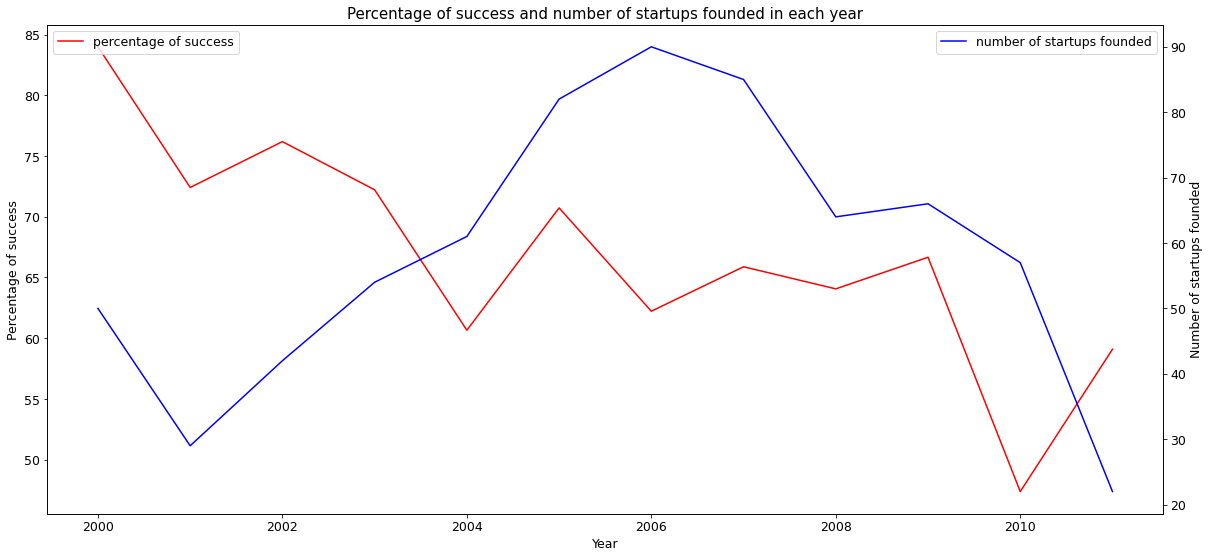

In [313]:
plt.figure(figsize=(20,9))
sns.lineplot(x=found_df_train.loc[2000:2011].index, y=found_df_train.loc[2000:2011]['pct_success'], color='r', label='percentage of success')
plt.ylabel('Percentage of success')
plt.xlabel('Year')
plt.legend(loc=2)
ax2 = plt.twinx()
sns.lineplot(x=found_df_train.loc[2000:2011].index, y=found_df_train.loc[2000:2011]['total'], ax=ax2, color='b', label='number of startups founded')
plt.ylabel('Number of startups founded')
plt.title('Percentage of success and number of startups founded in each year')
ax2.legend(loc=1)

- From 2000, the number of startups founded peaked around 2005-2007 and gradually declined around the time of financial crisis.
- The percentage of success was relatively high starting from 2000 and gradually dropped. During the financial crisis, the percentage of success slumped, consistent with the economic conditions.

## First and Last Funding
- Relevant columns:
 - ```'first_funding_at'```
 - ```'last_funding_at'```
 - ```'age_first_funding_year'```
 - ```'age_last_funding_year'```

- We will explore the relationship of funding period with success rate.

In [314]:
fund_df_train = df_train[['first_funding_at','last_funding_at', 'first_funding_year', 'last_funding_year', 'age_first_funding_year','age_last_funding_year','status','success']]

In [315]:
fund_df_train['diff_last_first_funding'] = (fund_df_train['last_funding_at'] - fund_df_train['first_funding_at']) / np.timedelta64(1, 'D')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [316]:
fund_df_train.corr()

,first_funding_year,last_funding_year,age_first_funding_year,age_last_funding_year,success,diff_last_first_funding
first_funding_year,1.00,0.62,-0.11,-0.40,-0.12,-0.49
last_funding_year,0.62,1.00,-0.21,0.06,0.06,0.37
age_first_funding_year,-0.11,-0.21,1.00,0.77,-0.10,-0.12
age_last_funding_year,-0.40,0.06,0.77,1.00,0.05,0.54
success,-0.12,0.06,-0.10,0.05,1.00,0.21
diff_last_first_funding,-0.49,0.37,-0.12,0.54,0.21,1.00


- There is a weak correlation (21%) between success and the time difference between first and last funding dates.

## Milestones
- Relevant columns:
 - ```'milestones'```
 - ```'age_first_milestone_year'```
 - ```'age_last_milestone_year'```

- Startup milestones are a growth timeline of integral startup accomplishments by tracking progress as the company grows and implements their plans.
- Startup milestones are "tracking marks" for both startup entrepreneurs and venture capitalists.
- Startup milestones are critical for raising funds from VCs because milestones illustrate competency or how well the firm achieved the key goals.

In [317]:
milestone_df_train = df_train[['milestones','age_first_milestone_year','age_last_milestone_year','success']]
milestone_df_train.corr()

,milestones,age_first_milestone_year,age_last_milestone_year,success
milestones,1.00,0.21,0.54,0.36
age_first_milestone_year,0.21,1.00,0.83,0.24
age_last_milestone_year,0.54,0.83,1.00,0.35
success,0.36,0.24,0.35,1.00


- There is a slight correlation of 36% between the number of milestones and success and 25% between age at last milestone and success.
- However, the correlation between age at first milestone and success is weaker at 14%.
- This means the later success could matter more than whether the firm reaches the first milestone quickly or not.

In [318]:
def milestone_group(x):
    if x <= 0:
        return '0'
    elif 0 < x <= 2:
        return '1-2'
    elif 2 < x <= 4:
        return '3-4'
    else:
        return '5+'


milestone_df_train['milestone_group'] = milestone_df_train['milestones'].apply(milestone_group)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [319]:
milestone_groupby_df_train = milestone_df_train[['milestones','success']].groupby('milestones').agg(
    success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)
milestone_groupby_df_train

,success,failure,total,pct_success,pct_failure
milestones,,,,,
0,33,87,120,27.50,72.50
1,117,85,202,57.92,42.08
2,141,55,196,71.94,28.06
3,116,29,145,80.00,20.00
4,40,8,48,83.33,16.67
5,20,2,22,90.91,9.09
6,4,0,4,100.00,0.00
8,1,0,1,100.00,0.00


In [320]:
milestone_groupby2_df_train = milestone_df_train[['milestone_group','success']].groupby('milestone_group').agg(
    success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)
milestone_groupby2_df_train

,success,failure,total,pct_success,pct_failure
milestone_group,,,,,
0,33,87,120,27.50,72.50
1-2,258,140,398,64.82,35.18
3-4,156,37,193,80.83,19.17
5+,25,2,27,92.59,7.41


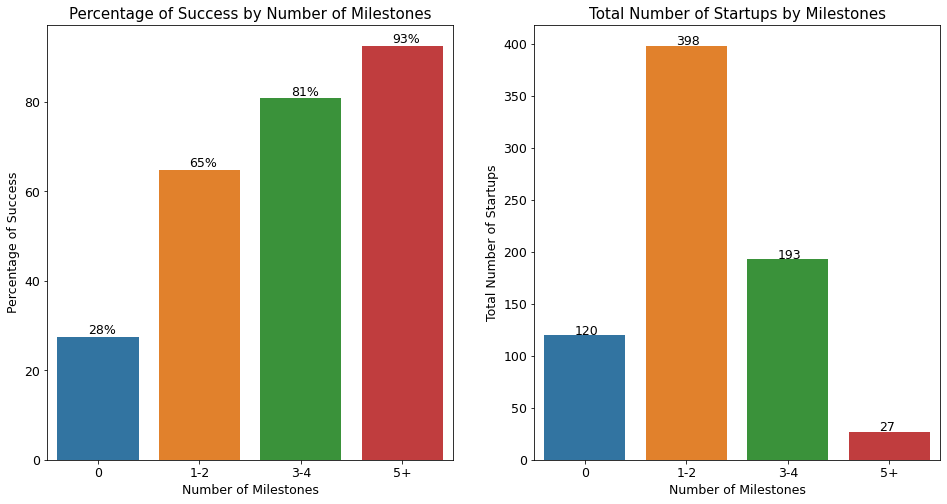

In [321]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))


# plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12.5})
ax[0] = sns.barplot(x=milestone_groupby2_df_train.index, y=milestone_groupby2_df_train['pct_success'],ax=ax[0])
ax[0].set_xlabel('Number of Milestones')
ax[0].set_ylabel('Percentage of Success')
ax[0].set_title('Percentage of Success by Number of Milestones')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

ax[1] = sns.barplot(x=milestone_groupby2_df_train.index, y=milestone_groupby2_df_train['total'],ax=ax[1])
ax[1].set_xlabel('Number of Milestones')
ax[1].set_ylabel('Total Number of Startups')
ax[1].set_title('Total Number of Startups by Milestones')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

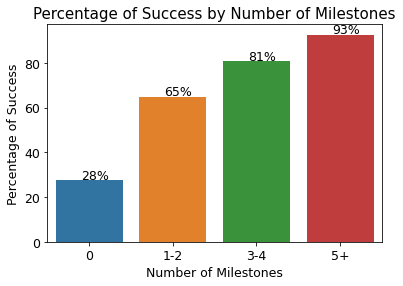

In [322]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=milestone_groupby2_df_train.index, y=milestone_groupby2_df_train['pct_success'])
ax.set_xlabel('Number of Milestones')
ax.set_ylabel('Percentage of Success')
ax.set_title('Percentage of Success by Number of Milestones')
for p in ax.patches:
   ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

- Once we group the number of milestones achieved by startups, we can see that the chance of success increases significantly as the number of milestones increases, illustrating the importance of milestones in running startups.

## Relationship
- Relevant columns:
 - ```'relationships'```
- This column indicates how many relationships a specific startup has. Such relationships include those with accountants, investors, vendors, mentors, researchers, etc.

In [323]:
relationship_df_train = df_train[['relationships','success']]
relationship_df_train.corr()

,relationships,success
relationships,1.00,0.36
success,0.36,1.00


In [324]:
def relationship_group(x):
    if x >= 17:
        return 17
    else:
        return x

relationship_df_train['relationship_group'] = relationship_df_train['relationships'].apply(relationship_group)
# Note that we will group startups with 17+ relationships to 17 relationship for simplicity of graph plottig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [325]:
relationship_group_df_train = relationship_df_train[['relationship_group','success']].groupby('relationship_group').agg(
    success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)
relationship_group_df_train

,success,failure,total,pct_success,pct_failure
relationship_group,,,,,
0,3,30,33,9.09,90.91
1,12,36,48,25.00,75.00
2,19,46,65,29.23,70.77
3,41,34,75,54.67,45.33
4,51,26,77,66.23,33.77
5,50,26,76,65.79,34.21
6,38,16,54,70.37,29.63
7,25,11,36,69.44,30.56
8,22,12,34,64.71,35.29


Text(0.5, 1.0, 'Percentage of Success by Number of Relationships')

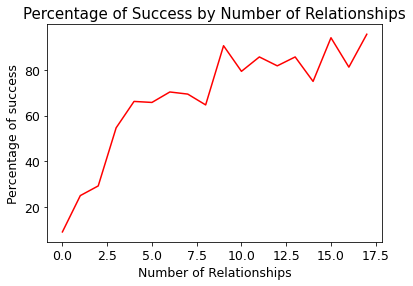

In [326]:
plt.figure(figsize=(6,4))
sns.lineplot(x=relationship_group_df_train.index, y=relationship_group_df_train['pct_success'], color='r')
plt.ylabel('Percentage of success')
plt.xlabel('Number of Relationships')
plt.title('Percentage of Success by Number of Relationships')

- There is a 36% correlation between the number of relationships and the success of the startups.
- From the graph, as the number of relationships increases, the percentage of success of the startups also increases. This means the startups with a higher number of relationships are more likely to succeed, illustrating the importance of relationships the startups must possess to run the business.

## Funding rounds (A/B/C/D)
- Relevant columns:
 - ```'has_roundA'```
 - ```'has_roundB'```
 - ```'has_roundC'```
 - ```'has_roundD'```
- Note that all four relevant columns are indicators (1/0).
- We will create new column ```'round_count'``` which sums the number of funding rounds a firm receives.

In [327]:
round_df_train = df_train[['has_roundA','has_roundB','has_roundC','has_roundD','success']]
round_df_train['round_count'] = round_df_train['has_roundA'] + round_df_train['has_roundB'] + round_df_train['has_roundC'] + round_df_train['has_roundD']
round_df_train.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,has_roundA,has_roundB,has_roundC,has_roundD,success,round_count
has_roundA,1.00,0.26,0.04,-0.06,0.21,0.59
has_roundB,0.26,1.00,0.34,0.08,0.19,0.74
has_roundC,0.04,0.34,1.00,0.33,0.16,0.67
has_roundD,-0.06,0.08,0.33,1.00,0.13,0.42
success,0.21,0.19,0.16,0.13,1.00,0.29
round_count,0.59,0.74,0.67,0.42,0.29,1.00


In [328]:
round_df_train.groupby(by=['has_roundA','has_roundB','has_roundC','has_roundD']).agg(
        success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)

success  failure  total  \
has_roundA has_roundB has_roundC has_roundD                            
0          0          0          0                85      110    195   
                                 1                19        5     24   
                      1          0                23       10     33   
                                 1                 6        3      9   
           1          0          0                32       28     60   
                                 1                 2        0      2   
                      1          0                17        9     26   
                                 1                 7        2      9   
1          0          0          0               109       62    171   
                                 1                 1        0      1   
                      1          0                 2        2      4   
                                 1                 3        0      3   
           1          0          0                91       24    115   
                      1          0                50        8     58   
                                 1                25        3     28   

                                             pct_success  pct_failure  
has_roundA has_roundB has_roundC has_roundD                            
0          0          0          0                 43.59        56.41  
                                 1                 79.17        20.83  
                      1          0                 69.70        30.30  
                                 1                 66.67        33.33  
           1          0          0                 53.33        46.67  
                                 1                100.00         0.00  
                      1          0                 65.38        34.62  
                                 1                 77.78        22.22  
1          0          0          0                 63.74        36.26  
                                 1                100.00         0.00  
                      1          0                 50.00        50.00  
                                 1                100.00         0.00  
           1          0          0                 79.13        20.87  
                      1          0                 86.21        13.79  
                                 1                 89.29        10.71

In [329]:
round_group_df_train = round_df_train.groupby(by=['round_count']).agg(
        success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)
round_group_df_train

,success,failure,total,pct_success,pct_failure
round_count,,,,,
0,85,110,195,43.59,56.41
1,183,105,288,63.54,36.46
2,119,38,157,75.80,24.20
3,60,10,70,85.71,14.29
4,25,3,28,89.29,10.71


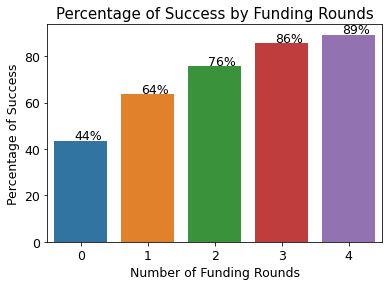

In [330]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=round_group_df_train.index, y=round_group_df_train['pct_success'])
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Percentage of Success')
plt.title('Percentage of Success by Funding Rounds')
for p in ax.patches:
   ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.5))

- There are positive correlations between the success of the startups and whether they received fundings in round A-D (13-21%).
- From the breakdown, startups without any funding rounds have less than 50% chances of success while startups with some funding rounds all have over 50% chance of success.
- Startups that secure funding from more rounds have higher chance of success.

## Total Funding Amount
- Relevant columns:
 - ```'funding_total_usd'```

In [331]:
funding_df_train = df_train[['funding_total_usd','success']]

In [332]:
funding_df_train['funding_total_usd_mn'] = funding_df_train['funding_total_usd']/1000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [333]:
funding_df_train['funding_total_usd_mn'].describe()

count    738.00
mean      27.34
std      211.54
min        0.01
25%        2.71
50%       10.00
75%       25.00
max     5700.00
Name: funding_total_usd_mn, dtype: float64

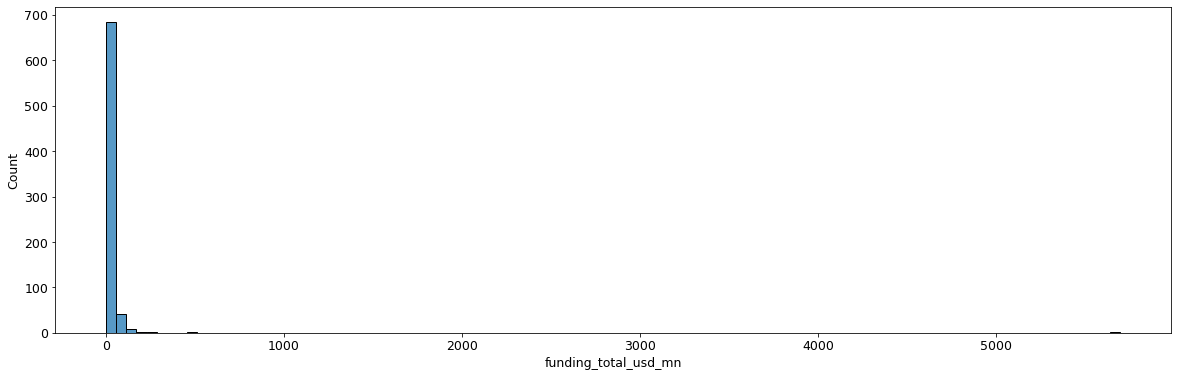

In [334]:
plt.figure(figsize=(20,6))
sns.histplot(funding_df_train['funding_total_usd_mn'],bins=100)

In [335]:
df_train.sort_values(by='funding_total_usd',ascending=False)[['state_code','city','name','funding_total_usd','success']].head(10)

,state_code,city,name,funding_total_usd,success
364,WA,Kirkland,Clearwire,5700000000,1
82,CO,Loveland,Abound Solar,510000000,0
497,IN,Indianapolis,ExactTarget,238209999,1
728,CA,Redwood City,Pearl Therapeutics,232000100,1
694,CA,San Jose,SolFocus,211403000,0
661,NC,Pittsboro,Biolex Therapeutics,162264126,0
780,CA,San Jose,CypherMax,148000000,0
590,CA,San Francisco,Yammer,142000000,1
727,CA,Milpitas,Virident Systems,129677153,1
109,CT,Bloomfield,Pocket Communications Northeast,125000000,0


In [336]:
funding_df_train.corr()

,funding_total_usd,success,funding_total_usd_mn
funding_total_usd,1.00,0.04,1.00
success,0.04,1.00,0.04
funding_total_usd_mn,1.00,0.04,1.00


In [337]:
df_train = df_train.drop([364])
funding_df_train = funding_df_train.drop([364])

In [338]:
funding_df_train.corr()

,funding_total_usd,success,funding_total_usd_mn
funding_total_usd,1.00,0.07,1.00
success,0.07,1.00,0.07
funding_total_usd_mn,1.00,0.07,1.00


- Based on the statistical description and histogram, there is an outlier (Clearwire) raising \$5.7 billion, the highest amount of funding and almost 10 times higher than the second place (\$0.51 billion). We decided to drop this row before training our ML models.
- There is a weak correlation of 7% between the total amount of funding and startup success after dropping the aforementioned row.

## Industry Types or Verticals
- Relevant columns:
 - ```'category_code'```
 - ```'is_software'```
 - ```'is_web'```
 - ```'is_mobile'```
 - ```'is_enterprise'```
 - ```'is_advertising'```
 - ```'is_gamesvideo'```
 - ```'is_ecommerce'```
 - ```'is_biotech'```
 - ```'is_consulting'```
 - ```'is_othercategory'```


In [339]:
category_df_train = df_train[['category_code','status']].groupby('category_code').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
).sort_values(by='total',ascending=False)

category_df_train

,success,failure,total,pct_success,pct_failure
category_code,,,,,
software,77,46,123,62.60,37.40
web,77,39,116,66.38,33.62
mobile,42,20,62,67.74,32.26
enterprise,47,14,61,77.05,22.95
advertising,37,14,51,72.55,27.45
games_video,24,20,44,54.55,45.45
network_hosting,19,8,27,70.37,29.63
biotech,17,10,27,62.96,37.04
semiconductor,16,9,25,64.00,36.00


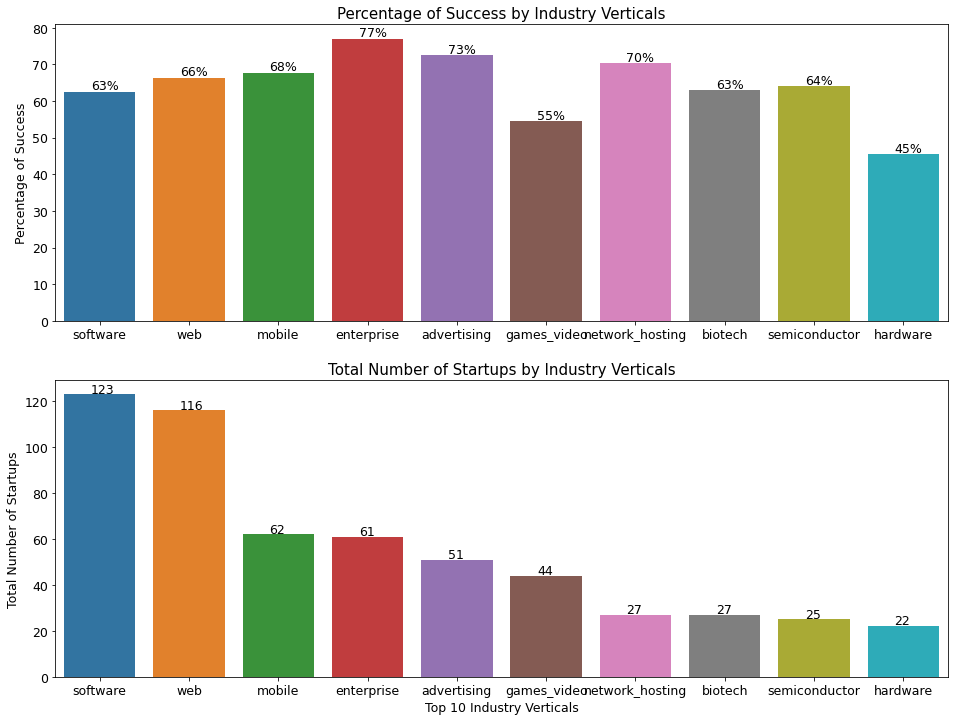

In [340]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

plt.rcParams.update({'font.size': 12.5})
ax[0] = sns.barplot(x=category_df_train[:10].index, y=category_df_train[:10]['pct_success'],ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage of Success')
ax[0].set_title('Percentage of Success by Industry Verticals')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

ax[1] = sns.barplot(x=category_df_train[:10].index, y=category_df_train[:10]['total'],ax=ax[1])
ax[1].set_xlabel('Top 10 Industry Verticals')
ax[1].set_ylabel('Total Number of Startups')
ax[1].set_title('Total Number of Startups by Industry Verticals')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.7))

- The two most popular industry verticals include software and web, with mobile and enterprise having almost half the number of startups of the first two.
- Almost all verticals in the top 10 are in or related to the technology industry.
- The success rate of hardware industry turns out to be the lowest at 45%, highlighting the fact that hardware is a more capital and R&D intensive than software industry. This nature of the industry exposes the firms to higher risks.
- The other verticals have around 60-70% success rate, with enterprise having the highest success rate of 77%, potentially due to the higher switching cost of the B2B channel.

## Venture Capital Backed Status
- Relevant columns:
 - ```has_VC```

In [341]:
vc_df_train = df_train[['has_VC','status']].groupby('has_VC').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
).sort_values(by='total',ascending=False)

vc_df_train

,success,failure,total,pct_success,pct_failure
has_VC,,,,,
0,331,165,496,66.73,33.27
1,140,101,241,58.09,41.91


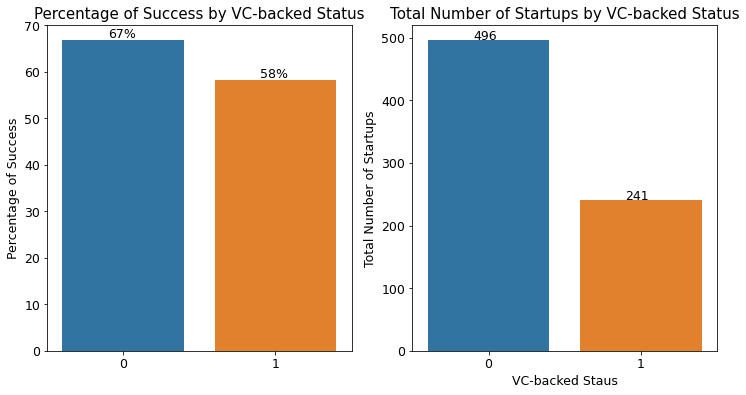

In [342]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plt.rcParams.update({'font.size': 12.5})
ax[0] = sns.barplot(x=vc_df_train[:10].index, y=vc_df_train[:10]['pct_success'],ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage of Success')
ax[0].set_title('Percentage of Success by VC-backed Status')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

ax[1] = sns.barplot(x=vc_df_train[:10].index, y=vc_df_train[:10]['total'],ax=ax[1])
ax[1].set_xlabel('VC-backed Staus')
ax[1].set_ylabel('Total Number of Startups')
ax[1].set_title('Total Number of Startups by VC-backed Status')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.7))

- The overall success rate of startups not backed by VCs turns out to be higher than VC-backed startups.

## Angel Investor Status
- Relevant columns:
 - ```'has_angel'```

In [343]:
angel_df_train = df_train[['has_angel','status']].groupby('has_angel').agg(
    success = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'acquired')),
    failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: sum(x == 'closed')),
    total = pd.NamedAgg(column = 'status', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'acquired')*100),
    pct_failure = pd.NamedAgg(column = 'status', aggfunc=lambda x: np.mean(x == 'closed')*100),
).sort_values(by='total',ascending=False)

angel_df_train

,success,failure,total,pct_success,pct_failure
has_angel,,,,,
0,358,188,546,65.57,34.43
1,113,78,191,59.16,40.84


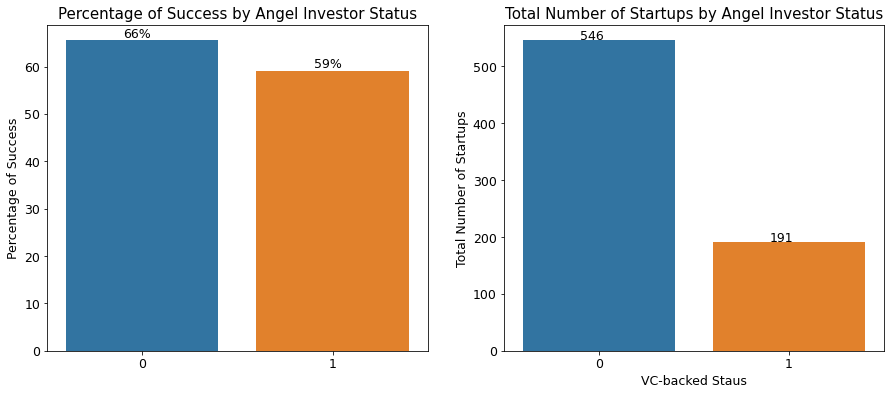

In [344]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

plt.rcParams.update({'font.size': 12.5})
ax[0] = sns.barplot(x=angel_df_train[:10].index, y=angel_df_train[:10]['pct_success'],ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage of Success')
ax[0].set_title('Percentage of Success by Angel Investor Status')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

ax[1] = sns.barplot(x=angel_df_train[:10].index, y=angel_df_train[:10]['total'],ax=ax[1])
ax[1].set_xlabel('VC-backed Staus')
ax[1].set_ylabel('Total Number of Startups')
ax[1].set_title('Total Number of Startups by Angel Investor Status')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.7))

- The overall success rate of startups not backed by angel investors turns out to be higher than angel-backed startups.

## Participants
- Relevant columns:
 - ```'avg_participants'```

In [345]:
participant_df_train = df_train[['avg_participants','success']]
participant_df_train.corr()

,avg_participants,success
avg_participants,1.00,0.18
success,0.18,1.00


- There is a weak correlation of 18% between the number of average participants and success.

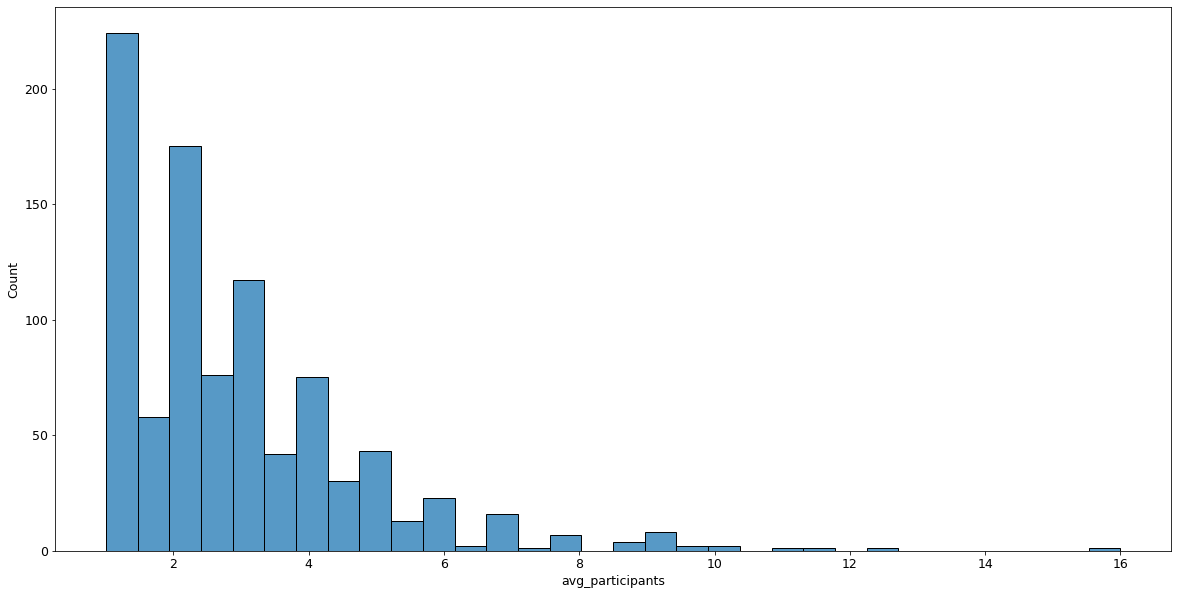

In [346]:
sns.histplot(df['avg_participants'])

In [347]:
def participant_group(x):
    if x <= 0:
        return '0'
    elif 0 < x <= 1:
        return '0-1'
    elif 1 < x <= 2:
        return '1-2'
    elif 2 < x <= 3:
        return '2-3'
    elif 3 < x <= 4:
        return '3-4'
    else:
        return '4+'


participant_df_train['participant_group'] = participant_df_train['avg_participants'].apply(participant_group)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [348]:
participant_groupby_df_train = participant_df_train[['participant_group','success']].groupby('participant_group').agg(
    success = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 1)),
    failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: sum(x == 0)),
    total = pd.NamedAgg(column = 'success', aggfunc='count'),
    pct_success = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 1)*100),
    pct_failure = pd.NamedAgg(column = 'success', aggfunc=lambda x: np.mean(x == 0)*100),
)
participant_groupby_df_train

,success,failure,total,pct_success,pct_failure
participant_group,,,,,
0-1,69,100,169,40.83,59.17
1-2,114,55,169,67.46,32.54
2-3,116,54,170,68.24,31.76
3-4,76,29,105,72.38,27.62
4+,96,28,124,77.42,22.58


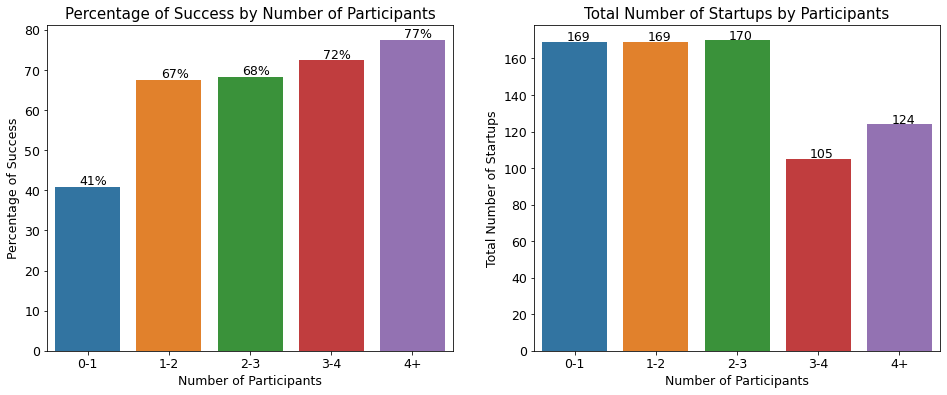

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


# plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12.5})
ax[0] = sns.barplot(x=participant_groupby_df_train.index, y=participant_groupby_df_train['pct_success'],ax=ax[0])
ax[0].set_xlabel('Number of Participants')
ax[0].set_ylabel('Percentage of Success')
ax[0].set_title('Percentage of Success by Number of Participants')
for p in ax[0].patches:
   ax[0].annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

ax[1] = sns.barplot(x=participant_groupby_df_train.index, y=participant_groupby_df_train['total'],ax=ax[1])
ax[1].set_xlabel('Number of Participants')
ax[1].set_ylabel('Total Number of Startups')
ax[1].set_title('Total Number of Startups by Participants')
for p in ax[1].patches:
   ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

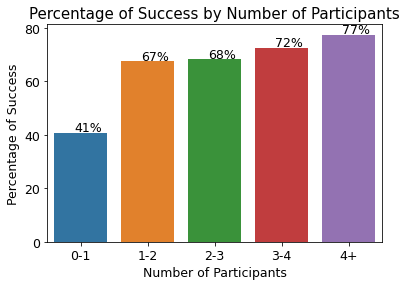

In [350]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 12.5})
ax = sns.barplot(x=participant_groupby_df_train.index, y=participant_groupby_df_train['pct_success'])
ax.set_xlabel('Number of Participants')
ax.set_ylabel('Percentage of Success')
ax.set_title('Percentage of Success by Number of Participants')
for p in ax.patches:
   ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.6))

- Once we group the number of milestones achieved by average participants, we can see that the chance of success tends to increase as the number of average participants increases.

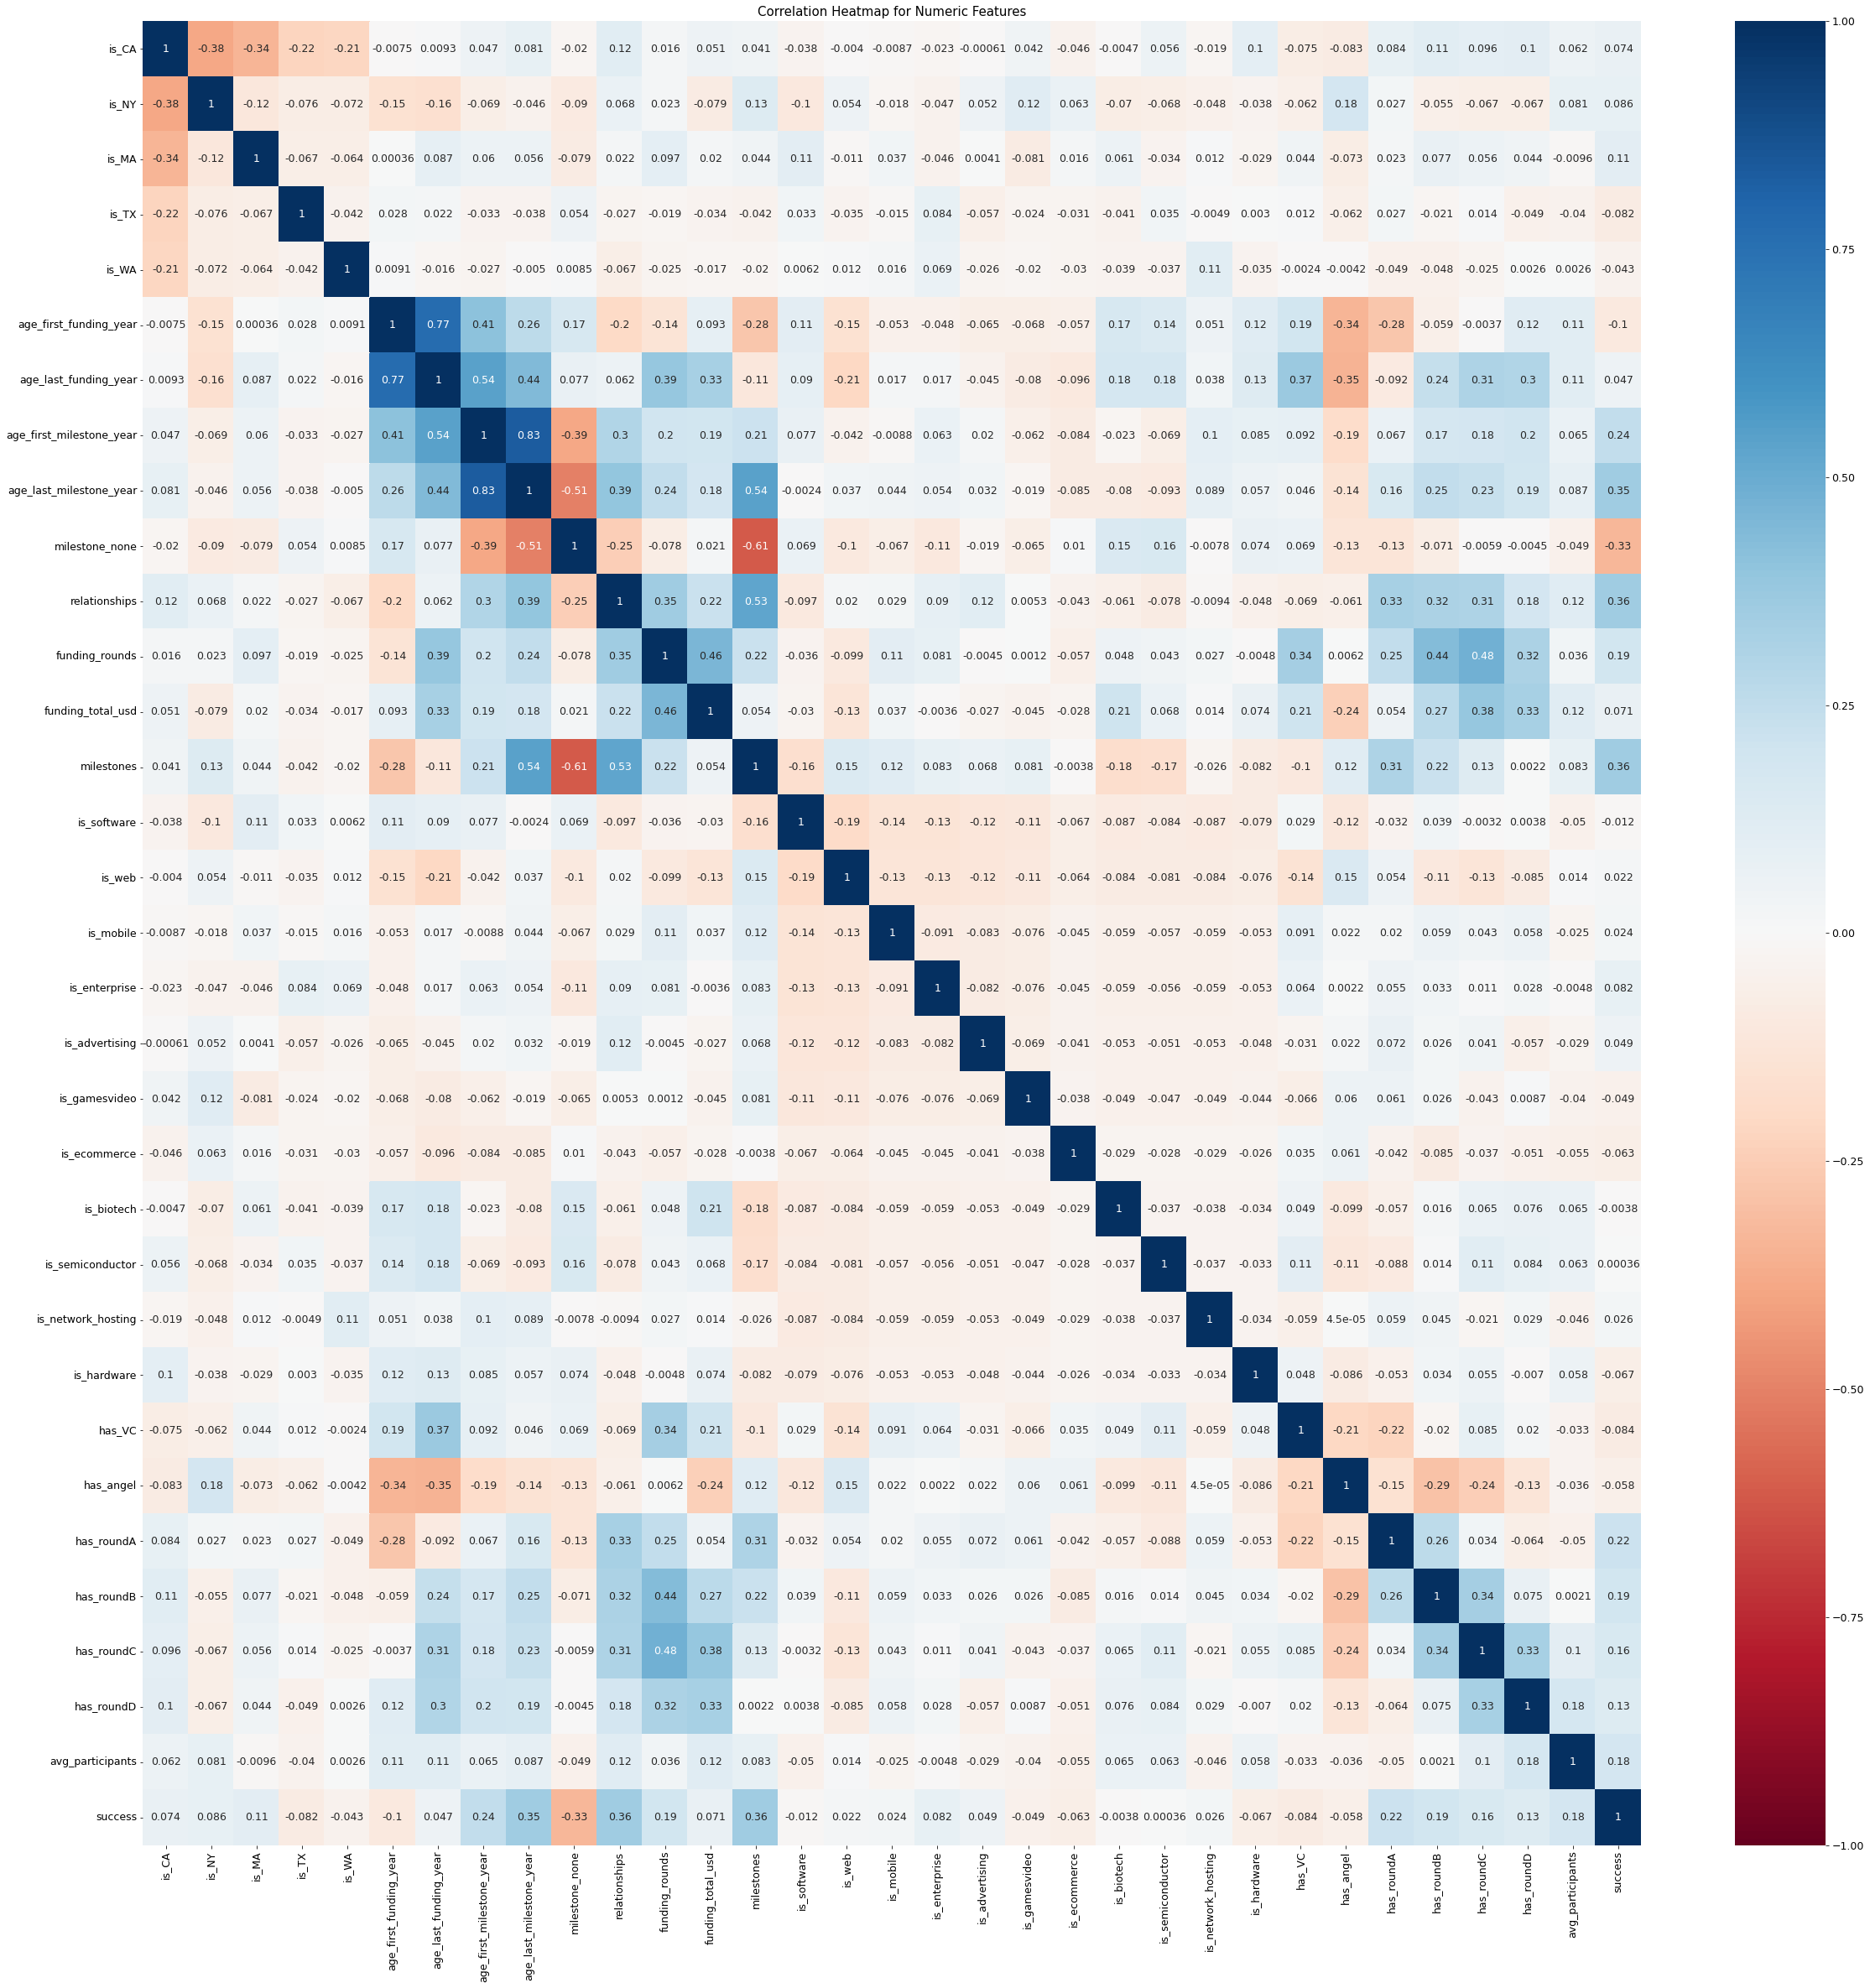

In [351]:
dummy = X.copy()
dummy.append('success')
corr_matrix = df_train[dummy].corr()
plt.figure(figsize=(40,40))
plt.title('Correlation Heatmap for Numeric Features', fontsize=15)
plt.xlabel('Features')
plt.ylabel('Features')
sns.heatmap(corr_matrix, cmap='RdBu', center = 0.0, vmax = 1.0, vmin = -1.0, annot=True)

# Machine Learning Models

In [352]:
x_train = df_train[X]
x_train.shape

(737, 32)

In [353]:
y_train = df_train[y]
y_train.shape

(737,)

In [354]:
x_test = df_test[X]
y_test = df_test[y]

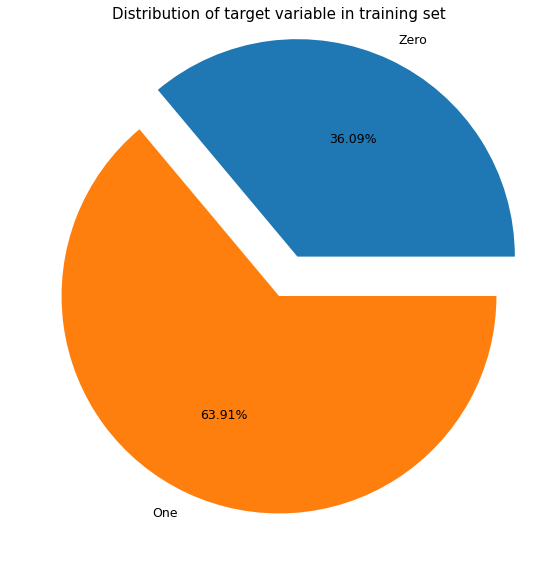

In [355]:
plt.title("Distribution of target variable in training set", size = 15)
plt.pie([len(y_train[y_train == 0.0]) / len(y_train), len(y_train[y_train == 1.0]) / len(y_train)], labels = ['Zero', 'One'], explode = [0.2, 0.0], autopct = '%1.2f%%')
plt.show()

## Model 0 (Baseline): Logistics Regression

In [356]:
res = sm.Logit(y_train, x_train).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.489530
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  737
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                           31
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.2514
Time:                        06:17:30   Log-Likelihood:                -360.78
converged:                       True   LL-Null:                       -481.96
Covariance Type:            nonrobust   LLR p-value:                 1.299e-34
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
is_CA                        0.0057      0.237      0.024      0.981      -0.458       0.470
is_NY                        0.5257      0.358      1.470      0.141      -0.175       1.226
is_MA                        0.6059      0.396      1.530      0.126      -0.170       1.382
is_TX                       -0.9681      0.494     -1.960      0.050      -1.936      -0.000
is_WA                       -0.4045      0.485     -0.834      0.404      -1.355       0.546
age_first_funding_year      -0.1375      0.097     -1.425      0.154      -0.327       0.052
age_last_funding_year       -0.0089      0.095     -0.093      0.926      -0.196       0.178
age_first_milestone_year    -0.1372      0.085     -1.615      0.106      -0.304       0.029
age_last_milestone_year      0.2534      0.082      3.093      0.002       0.093       0.414
milestone_none              -1.3378      0.339     -3.943      0.000      -2.003      -0.673
relationships                0.1052      0.025      4.210      0.000       0.056       0.154
funding_rounds               0.0780      0.125      0.624      0.533      -0.167       0.323
funding_total_usd        -5.909e-09   4.47e-09     -1.322      0.186   -1.47e-08    2.85e-09
milestones                  -0.1533      0.141     -1.085      0.278      -0.430       0.124
is_software                  0.0688      0.289      0.238      0.812      -0.497       0.634
is_web                      -0.2600      0.293     -0.886      0.376      -0.835       0.315
is_mobile                   -0.1353      0.375     -0.361      0.718      -0.870       0.599
is_enterprise                0.3967      0.400      0.992      0.321      -0.387       1.180
is_advertising              -0.1124      0.410     -0.274      0.784      -0.916       0.691
is_gamesvideo               -0.7540      0.404     -1.868      0.062      -1.545       0.037
is_ecommerce                -0.5888      0.598     -0.984      0.325      -1.761       0.583
is_biotech                   0.8115      0.565      1.437      0.151      -0.296       1.919
is_semiconductor             1.0453      0.556      1.879      0.060      -0.045       2.136
is_network_hosting           0.1635      0.548      0.299      0.765      -0.910       1.237
is_hardware                 -0.6703      0.570     -1.177      0.239      -1.787       0.446
has_VC                      -0.4984      0.260     -1.917      0.055      -1.008       0.011
has_angel                   -0.7348      0.274     -2.685      0.007      -1.271      -0.198
has_roundA                   0.0565      0.236      0.240      0.811      -0.406       0.519
has_roundB                  -0.0074      0.250     -0.030      0.976      -0.497       0.482
has_roundC                   0.1275      0.314      0.406      0.684      -0.487       0.742
has_roundD                   0.6425      0.446      1.439      0.150      -0.233       1.518
avg_participants             0.1327      0.054      2.455      0.014       0.02

In [357]:
np.exp(res.params)

is_CA                      1.01
is_NY                      1.69
is_MA                      1.83
is_TX                      0.38
is_WA                      0.67
age_first_funding_year     0.87
age_last_funding_year      0.99
age_first_milestone_year   0.87
age_last_milestone_year    1.29
milestone_none             0.26
relationships              1.11
funding_rounds             1.08
funding_total_usd          1.00
milestones                 0.86
is_software                1.07
is_web                     0.77
is_mobile                  0.87
is_enterprise              1.49
is_advertising             0.89
is_gamesvideo              0.47
is_ecommerce               0.55
is_biotech                 2.25
is_semiconductor           2.84
is_network_hosting         1.18
is_hardware                0.51
has_VC                     0.61
has_angel                  0.48
has_roundA                 1.06
has_roundB                 0.99
has_roundC                 1.14
has_roundD                 1.90
avg_part

We can interpret each coefficient as follows: for every one unit increase in the X variable, the probability that the startup succeeds is the corresponding ```coefficient``` times as large as the probability that startup fails (holding all else equal).

For example, for every one year increase in the age at last milestone, the probability that a startup is successful is 1.29 times as large as the probability that a startup fails. This indicates that firms that are older and still experiencing growth are more likely to succeed.

###Prediction

In [ ]:
# Instantiate model
LR = LogisticRegression(penalty='l2',
                        fit_intercept=False, # data include intercept
                        solver='newton-cg', 
                        max_iter=500,
                        multi_class='ovr')
# Fit model
LR.fit(x_train, y_train)
# Predict
train_pred = LR.predict(x_train)

###Cross Validation

In [ ]:
num_folds = 3
yhat = cross_val_predict(LR, x_train, y_train, cv = num_folds, method='predict')
shat = cross_val_predict(LR, x_train, y_train, cv = num_folds, method='decision_function')
assert yhat.shape[0] == x_train.shape[0] == y_train.shape[0]
cv_score_accuracy = cross_val_score(LR, x_train, y_train, cv=num_folds, scoring='accuracy')
cv_score_precision = cross_val_score(LR, x_train, y_train, cv=num_folds, scoring='precision')
cv_score_recall = cross_val_score(LR, x_train, y_train, cv=num_folds, scoring='recall')

In [360]:
m = (train_pred != yhat).sum()
print(f"Different predictions: {m:,} ({m/len(yhat):.2%})")
print()
print(f"CV avg model accuracy: {cv_score_accuracy.mean():.2%}")
print(f"CV min model accuracy: {cv_score_accuracy.min():.2%}")
print(f"CV max model accuracy: {cv_score_accuracy.max():.2%}")
print()
print(f"CV avg model precision: {cv_score_precision.mean():.2%}")
print(f"CV min model precision: {cv_score_precision.min():.2%}")
print(f"CV max model precision: {cv_score_precision.max():.2%}")
print()
print(f"CV avg model recall: {cv_score_recall.mean():.2%}")
print(f"CV min model recall: {cv_score_recall.min():.2%}")
print(f"CV max model recall: {cv_score_recall.max():.2%}")

Different predictions: 49 (6.65%)

CV avg model accuracy: 73.95%
CV min model accuracy: 72.65%
CV max model accuracy: 75.20%

CV avg model precision: 76.40%
CV min model precision: 74.73%
CV max model precision: 77.51%

CV avg model recall: 85.77%
CV min model recall: 83.44%
CV max model recall: 87.26%


###Confusion Matrix
<table>
    <tr>
        <td> </td>
        <td colspan="2"><center>Predicted</center></td>
    </tr>
    <tr>
        <td>Actual</td>
        <td><center>0</center></td>
        <td><center>1</center></td>
    </tr>
    <tr>
        <td><center>0</center></td>
        <td>True Negative</td>
        <td>False Positive</td>
    </tr>
    <tr>
        <td><center>1</center></td>
        <td>False Negative</td>
        <td>True Positive</td>
    </tr>
</table>

In [361]:
# confusion matrix
cm = confusion_matrix(y_train, yhat)
# format
x = pd.DataFrame(cm).assign(rowprob = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'colsum'}).style.format("{:,}")

,0,1,rowprob
0,141,125,266
1,67,404,471
colsum,208,529,737


In [362]:
# joint distribution (probability matrix)
pm = cm/cm.sum()
x = pd.DataFrame(pm).assign(pact = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'ppred'}).style.format("{:.2%}")

,0,1,pact
0,19.13%,16.96%,36.09%
1,9.09%,54.82%,63.91%
ppred,28.22%,71.78%,100.00%


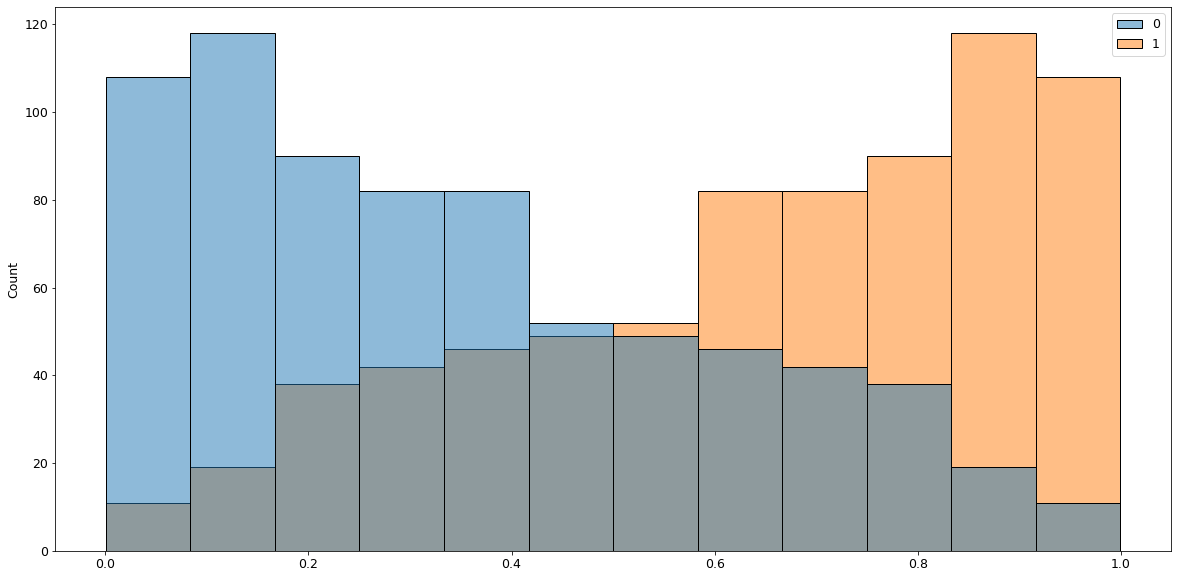

In [363]:
sns.histplot(LR.predict_proba(x_train))
plt.show()

###Accuracy

In [364]:
# Accuracy
accuracy = accuracy_score(y_train, yhat)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 73.95%


###Precision

In [365]:
# Precision
precision = precision_score(y_train, yhat)
print(f"Precision: {precision:.2%}")

Precision: 76.37%


###Recall

In [366]:
recall = recall_score(y_train, yhat)
print(f"Recall: {recall:.2%}")

Recall: 85.77%


###Exploring Optimal Threshold

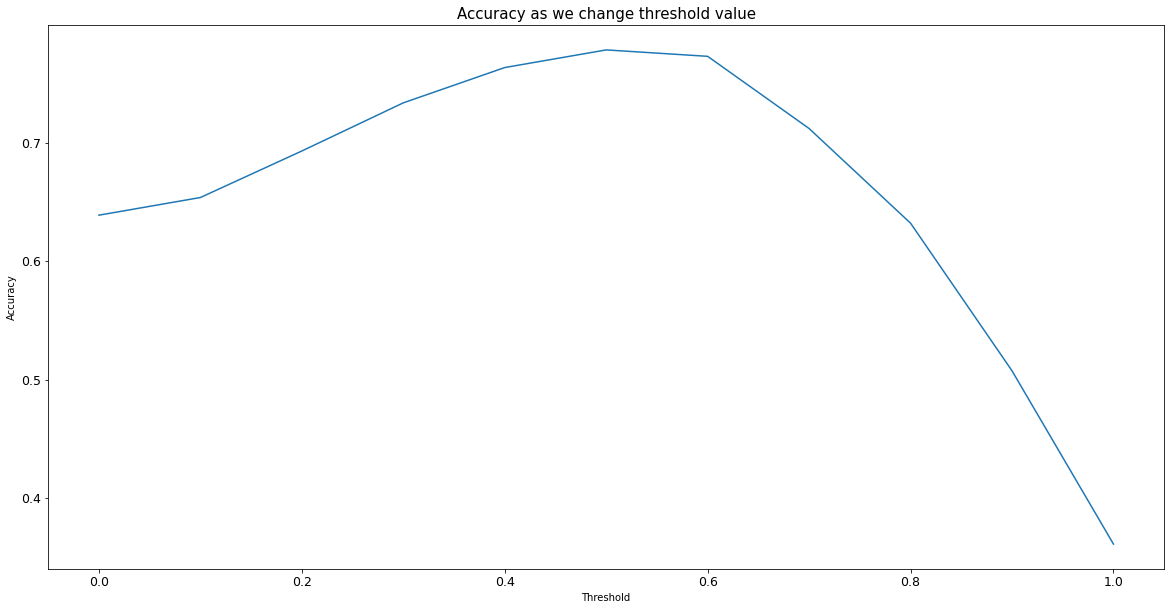

In [367]:
yhat_proba = LR.predict_proba(x_train)[:,1]
thresholds = [i/10 for i in range(11)]

scores = [np.sum([0.0 if i < threshold else 1.0 for i in yhat_proba] == y_train) / len(y_train) for threshold in thresholds]

plt.title("Accuracy as we change threshold value", size=15)
plt.plot(thresholds, scores)
plt.xlabel("Threshold", size = 10)
plt.ylabel("Accuracy", size = 10)
plt.show()

In [368]:
best_score = np.max(scores)
best_threshold = thresholds[np.argmax(scores)]
best_threshold

0.5

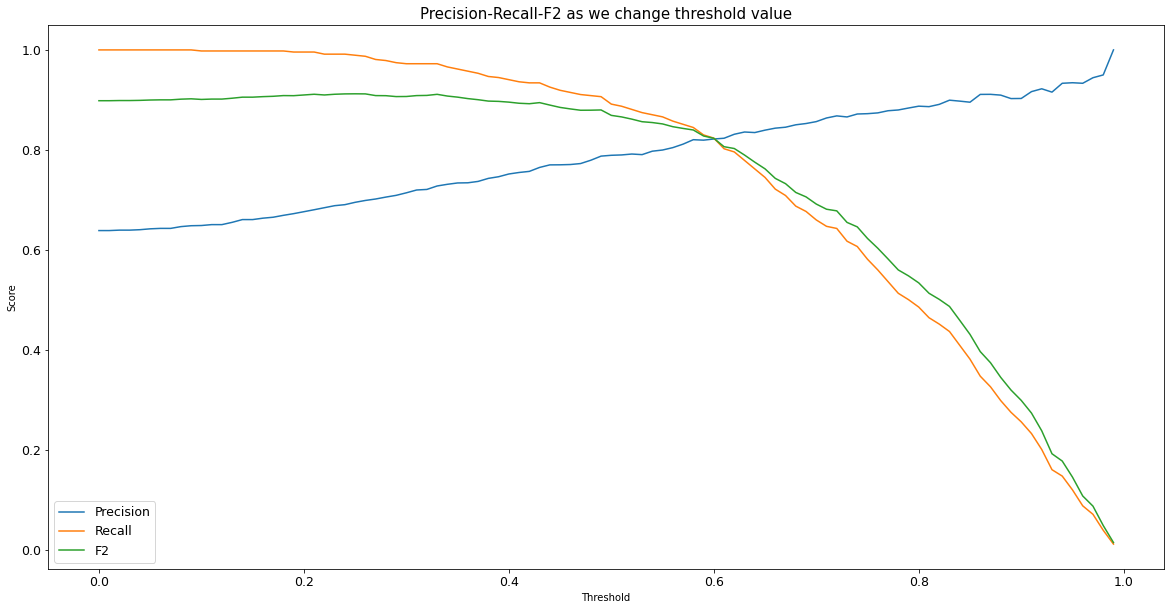

In [369]:
thresholds = [i/100 for i in range(0, 100)]
precisions = [precision_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
recalls = [recall_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
fbeta = [fbeta_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba],beta = 2) for threshold in thresholds]

plt.title("Precision-Recall-F2 as we change threshold value", size=15)
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fbeta)
plt.legend(['Precision', 'Recall', 'F2'])
plt.xlabel("Threshold", size = 10)
plt.ylabel("Score", size = 10)
plt.show()

In [370]:
best_fbeta = np.max(fbeta)
best_threshold = thresholds[np.argmax(fbeta)]
final_thresholds = [best_threshold]
best_threshold

0.25

##Model 1: Random Forest

In [371]:
# Instantiate RF with some chosen hyperparameters
rf = RandomForestClassifier(random_state=SEED)
rf.fit(x_train, y_train)
train_pred_rf = rf.predict(x_train)

###GridSearchCV for best hyperparameters

In [372]:
from sklearn.metrics import make_scorer
# Choosing potential parameters to explore 
# Apply GridSearchCV to find the optimal features for RandomForestClassifier
param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'max_depth' : [2,3,4,5,10,15]
}

fhalf_scorer = make_scorer(fbeta_score, beta=2)
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=fhalf_scorer)
CV_rfc.fit(x_train, y_train)
rf_best_params = CV_rfc.best_params_ # finding best parameters
print(rf_best_params)

{'max_depth': 3, 'n_estimators': 50}


In [373]:
# Re-instantiation with best hyperparameters
rf = RandomForestClassifier(max_depth = rf_best_params['max_depth'], n_estimators = rf_best_params['n_estimators'])
rf.fit(x_train, y_train)
train_pred_rf = rf.predict(x_train)

###Cross Validation

In [374]:
num_folds = 3
yhat_rf = cross_val_predict(rf, x_train, y_train, cv = num_folds, method='predict')
shat_rf = cross_val_predict(rf, x_train, y_train, cv = num_folds)
assert yhat_rf.shape[0] == x_train.shape[0] == y_train.shape[0]
cv_score_accuracy_rf = cross_val_score(rf, x_train, y_train, cv=num_folds, scoring='accuracy')
cv_score_precision_rf = cross_val_score(rf, x_train, y_train, cv=num_folds, scoring='precision')
cv_score_recall_rf = cross_val_score(rf, x_train, y_train, cv=num_folds, scoring='recall')

In [375]:
m = (train_pred_rf != yhat_rf).sum()
print(f"Different predictions: {m:,} ({m/len(yhat_rf):.2%})")
print()
print(f"CV avg model accuracy: {cv_score_accuracy_rf.mean():.2%}")
print(f"CV min model accuracy: {cv_score_accuracy_rf.min():.2%}")
print(f"CV max model accuracy: {cv_score_accuracy_rf.max():.2%}")
print()
print(f"CV avg model precision: {cv_score_precision_rf.mean():.2%}")
print(f"CV min model precision: {cv_score_precision_rf.min():.2%}")
print(f"CV max model precision: {cv_score_precision_rf.max():.2%}")
print()
print(f"CV avg model recall: {cv_score_recall_rf.mean():.2%}")
print(f"CV min model recall: {cv_score_recall_rf.min():.2%}")
print(f"CV max model recall: {cv_score_recall_rf.max():.2%}")

Different predictions: 39 (5.29%)

CV avg model accuracy: 77.34%
CV min model accuracy: 75.92%
CV max model accuracy: 80.08%

CV avg model precision: 77.21%
CV min model precision: 75.39%
CV max model precision: 78.65%

CV avg model recall: 92.14%
CV min model recall: 89.81%
CV max model recall: 96.18%


###Confusion Matrix
<table>
    <tr>
        <td> </td>
        <td colspan="2"><center>Predicted</center></td>
    </tr>
    <tr>
        <td>Actual</td>
        <td><center>0</center></td>
        <td><center>1</center></td>
    </tr>
    <tr>
        <td><center>0</center></td>
        <td>True Negative</td>
        <td>False Positive</td>
    </tr>
    <tr>
        <td><center>1</center></td>
        <td>False Negative</td>
        <td>True Positive</td>
    </tr>
</table>

In [376]:
# confusion matrix
cm = confusion_matrix(y_train, yhat_rf)
# format
x = pd.DataFrame(cm).assign(rowprob = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'colsum'}).style.format("{:,}")

,0,1,rowprob
0,138,128,266
1,40,431,471
colsum,178,559,737


In [377]:
# joint distribution (probability matrix)
pm = cm/cm.sum()
x = pd.DataFrame(pm).assign(pact = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'ppred'}).style.format("{:.2%}")

,0,1,pact
0,18.72%,17.37%,36.09%
1,5.43%,58.48%,63.91%
ppred,24.15%,75.85%,100.00%


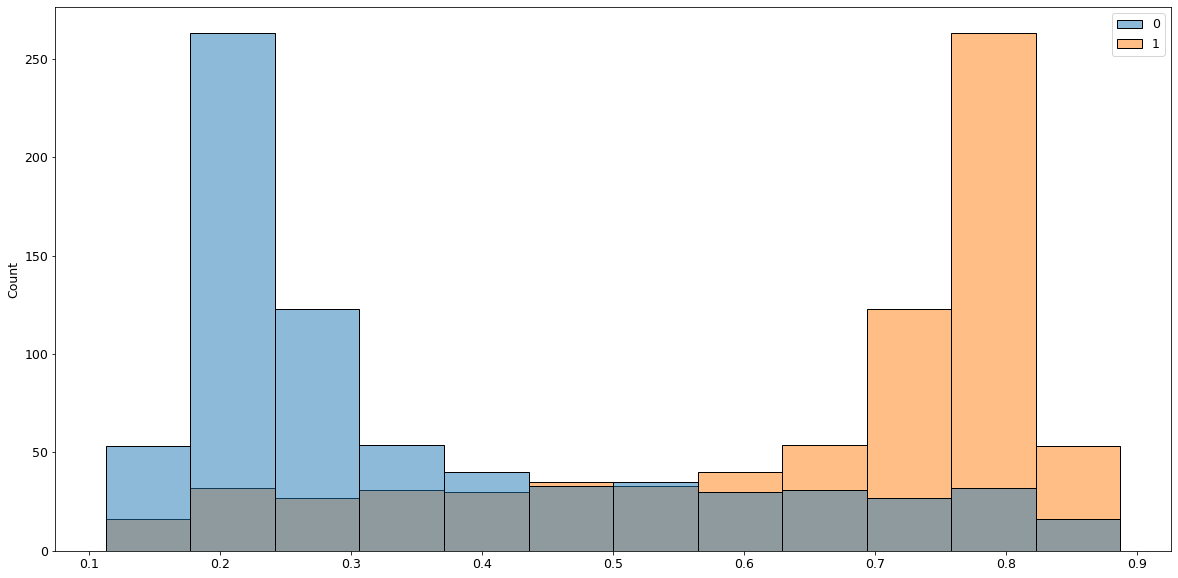

In [378]:
sns.histplot(rf.predict_proba(x_train))
plt.show()

###Accuracy

In [379]:
# Accuracy
accuracy = accuracy_score(y_train, yhat_rf)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 77.20%


###Precision

In [380]:
# Precision
precision = precision_score(y_train, yhat_rf)
print(f"Precision: {precision:.2%}")

Precision: 77.10%


###Recall

In [381]:
recall = recall_score(y_train, yhat_rf)
print(f"Recall: {recall:.2%}")

Recall: 91.51%


###Exploring Optimal Threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

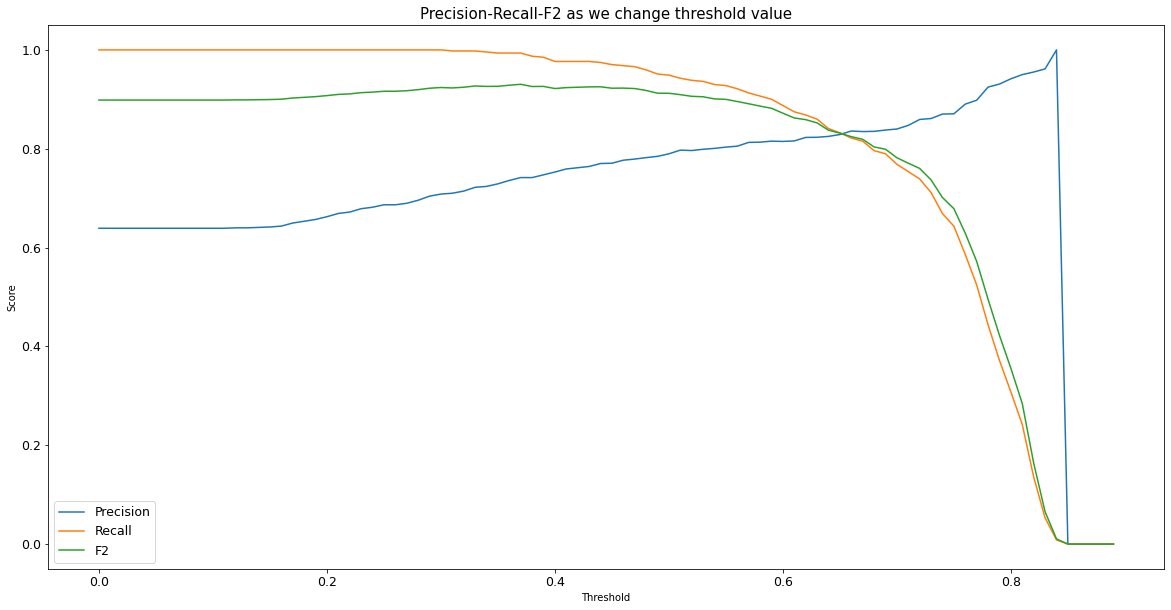

In [382]:
yhat_proba = rf.predict_proba(x_train)[:, 1]
thresholds = [i/100 for i in range(0, 90)]
precisions = [precision_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
recalls = [recall_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
fbeta = [fbeta_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba],beta = 2) for threshold in thresholds]

plt.title("Precision-Recall-F2 as we change threshold value", size=15)
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fbeta)
plt.legend(['Precision', 'Recall', 'F2'])
plt.xlabel("Threshold", size = 10)
plt.ylabel("Score", size = 10)
plt.show()

In [383]:
best_fbeta = np.max(fbeta)
best_threshold = thresholds[np.argmax(fbeta)]
final_thresholds.append(best_threshold)
best_threshold

0.37

##Model 2: XGBoost

In [384]:
# Instantiate RF with some chosen hyperparameters
xgbcl = XGBClassifier() #XGBoost classifier
xgbcl.fit(x_train, y_train)
train_pred_xgbcl = xgbcl.predict(x_train)

###GridSearchCV for best hyperparameters

In [385]:
# Choosing potential parameters to explore 
# Apply GridSearchCV to find the optimal features for RandomForestClassifier
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [2, 4, 5, 10, 15]
}

fhalf_scorer = make_scorer(fbeta_score, beta=2)
CV_xgbc = GridSearchCV(estimator=xgbcl, param_grid=param_grid, cv=3, scoring=fhalf_scorer)
CV_xgbc.fit(x_train, y_train)
xgbc_best_params = CV_xgbc.best_params_ # finding best parameters
print(xgbc_best_params)

{'max_depth': 2, 'n_estimators': 50}


In [386]:
# Re-instantiation with best hyperparameters
xgbcl = RandomForestClassifier(max_depth = xgbc_best_params['max_depth'], n_estimators = xgbc_best_params['n_estimators'])
xgbcl.fit(x_train, y_train)
train_pred_xgbcl = xgbcl.predict(x_train)

###Cross Validation

In [387]:
num_folds = 3
yhat_xgbcl = cross_val_predict(xgbcl, x_train, y_train, cv = num_folds, method='predict')
shat_xgbcl = cross_val_predict(xgbcl, x_train, y_train, cv = num_folds)
assert yhat_xgbcl.shape[0] == x_train.shape[0] == y_train.shape[0]
cv_score_accuracy_xgb = cross_val_score(xgbcl, x_train, y_train, cv=num_folds, scoring='accuracy')
cv_score_precision_xgb = cross_val_score(xgbcl, x_train, y_train, cv=num_folds, scoring='precision')
cv_score_recall_xgb = cross_val_score(xgbcl, x_train, y_train, cv=num_folds, scoring='recall')

In [388]:
m = (train_pred_xgbcl != yhat_xgbcl).sum()
print(f"Different predictions: {m:,} ({m/len(yhat_xgbcl):.2%})")
print()
print(f"CV avg model accuracy: {cv_score_accuracy_xgb.mean():.2%}")
print(f"CV min model accuracy: {cv_score_accuracy_xgb.min():.2%}")
print(f"CV max model accuracy: {cv_score_accuracy_xgb.max():.2%}")
print()
print(f"CV avg model precision: {cv_score_precision_xgb.mean():.2%}")
print(f"CV min model precision: {cv_score_precision_xgb.min():.2%}")
print(f"CV max model precision: {cv_score_precision_xgb.max():.2%}")
print()
print(f"CV avg model recall: {cv_score_recall_xgb.mean():.2%}")
print(f"CV min model recall: {cv_score_recall_xgb.min():.2%}")
print(f"CV max model recall: {cv_score_recall_xgb.max():.2%}")

Different predictions: 25 (3.39%)

CV avg model accuracy: 75.85%
CV min model accuracy: 73.58%
CV max model accuracy: 78.86%

CV avg model precision: 76.52%
CV min model precision: 75.25%
CV max model precision: 77.16%

CV avg model recall: 91.30%
CV min model recall: 85.99%
CV max model recall: 94.90%


###Confusion Matrix
<table>
    <tr>
        <td> </td>
        <td colspan="2"><center>Predicted</center></td>
    </tr>
    <tr>
        <td>Actual</td>
        <td><center>0</center></td>
        <td><center>1</center></td>
    </tr>
    <tr>
        <td><center>0</center></td>
        <td>True Negative</td>
        <td>False Positive</td>
    </tr>
    <tr>
        <td><center>1</center></td>
        <td>False Negative</td>
        <td>True Positive</td>
    </tr>
</table>

In [389]:
# confusion matrix
cm = confusion_matrix(y_train, yhat_xgbcl)
# format
x = pd.DataFrame(cm).assign(rowprob = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'colsum'}).style.format("{:,}")

,0,1,rowprob
0,128,138,266
1,37,434,471
colsum,165,572,737


In [390]:
# joint distribution (probability matrix)
pm = cm/cm.sum()
x = pd.DataFrame(pm).assign(pact = lambda x: x.sum(axis=1))
b = pd.DataFrame(x.sum(axis=0)).T
pd.concat((x,b),axis=0,ignore_index=True).rename(index={2:'ppred'}).style.format("{:.2%}")

,0,1,pact
0,17.37%,18.72%,36.09%
1,5.02%,58.89%,63.91%
ppred,22.39%,77.61%,100.00%


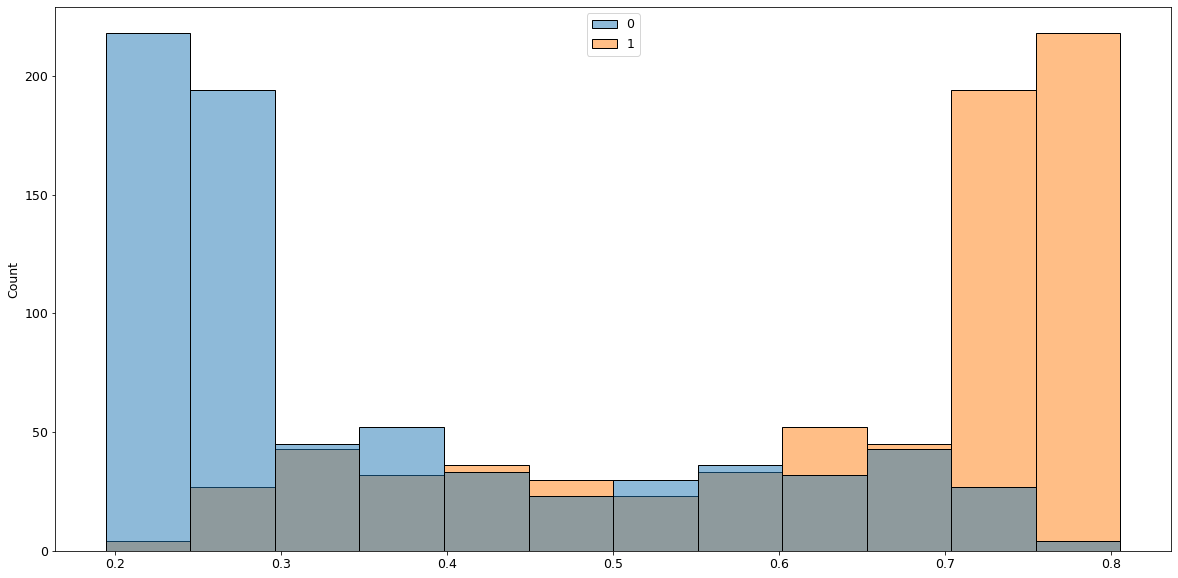

In [391]:
sns.histplot(xgbcl.predict_proba(x_train))
plt.show()

###Accuracy

In [392]:
# Accuracy
accuracy = accuracy_score(y_train, yhat_xgbcl)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 76.26%


###Precision

In [393]:
# Precision
precision = precision_score(y_train, yhat_xgbcl)
print(f"Precision: {precision:.2%}")

Precision: 75.87%


###Recall

In [394]:
recall = recall_score(y_train, yhat_xgbcl)
print(f"Recall: {recall:.2%}")

Recall: 92.14%


###Exploring Optimal Threshold

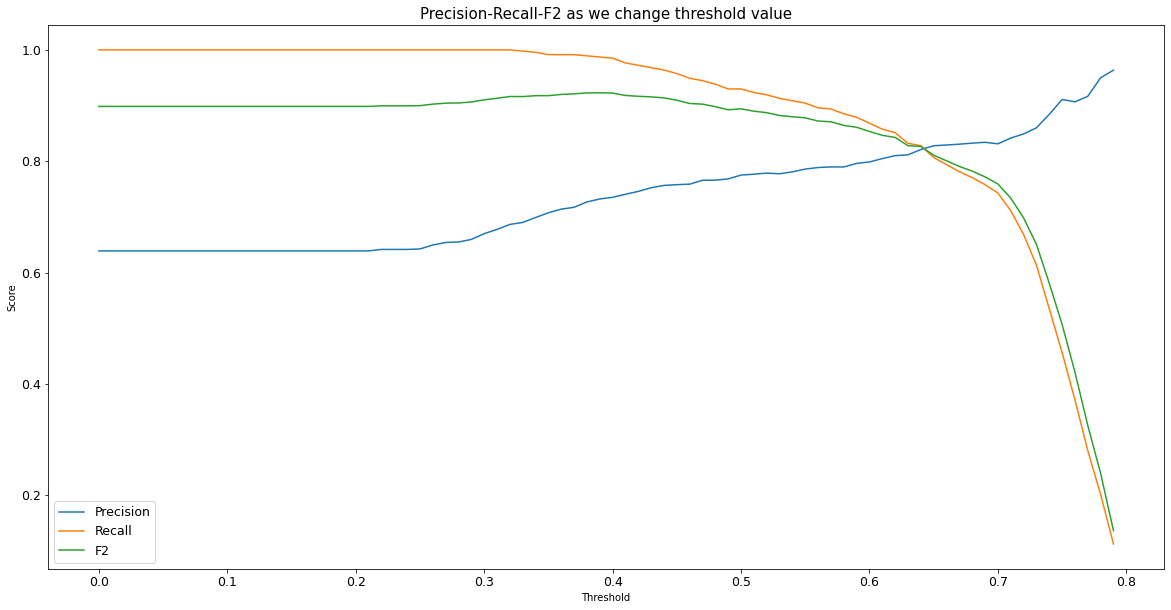

In [395]:
yhat_proba = xgbcl.predict_proba(x_train)[:, 1]
thresholds = [i/100 for i in range(0, 80)]
precisions = [precision_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
recalls = [recall_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba]) for threshold in thresholds]
fbeta = [fbeta_score(y_train, [0.0 if i < threshold else 1.0 for i in yhat_proba],beta = 2) for threshold in thresholds]

plt.title("Precision-Recall-F2 as we change threshold value", size=15)
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fbeta)
plt.legend(['Precision', 'Recall', 'F2'])
plt.xlabel("Threshold", size = 10)
plt.ylabel("Score", size = 10)
plt.show()

In [396]:
best_fbeta = np.max(fbeta)
best_threshold = thresholds[np.argmax(fbeta)]
final_thresholds.append(best_threshold)
best_threshold

0.39

#Choosing Best Model

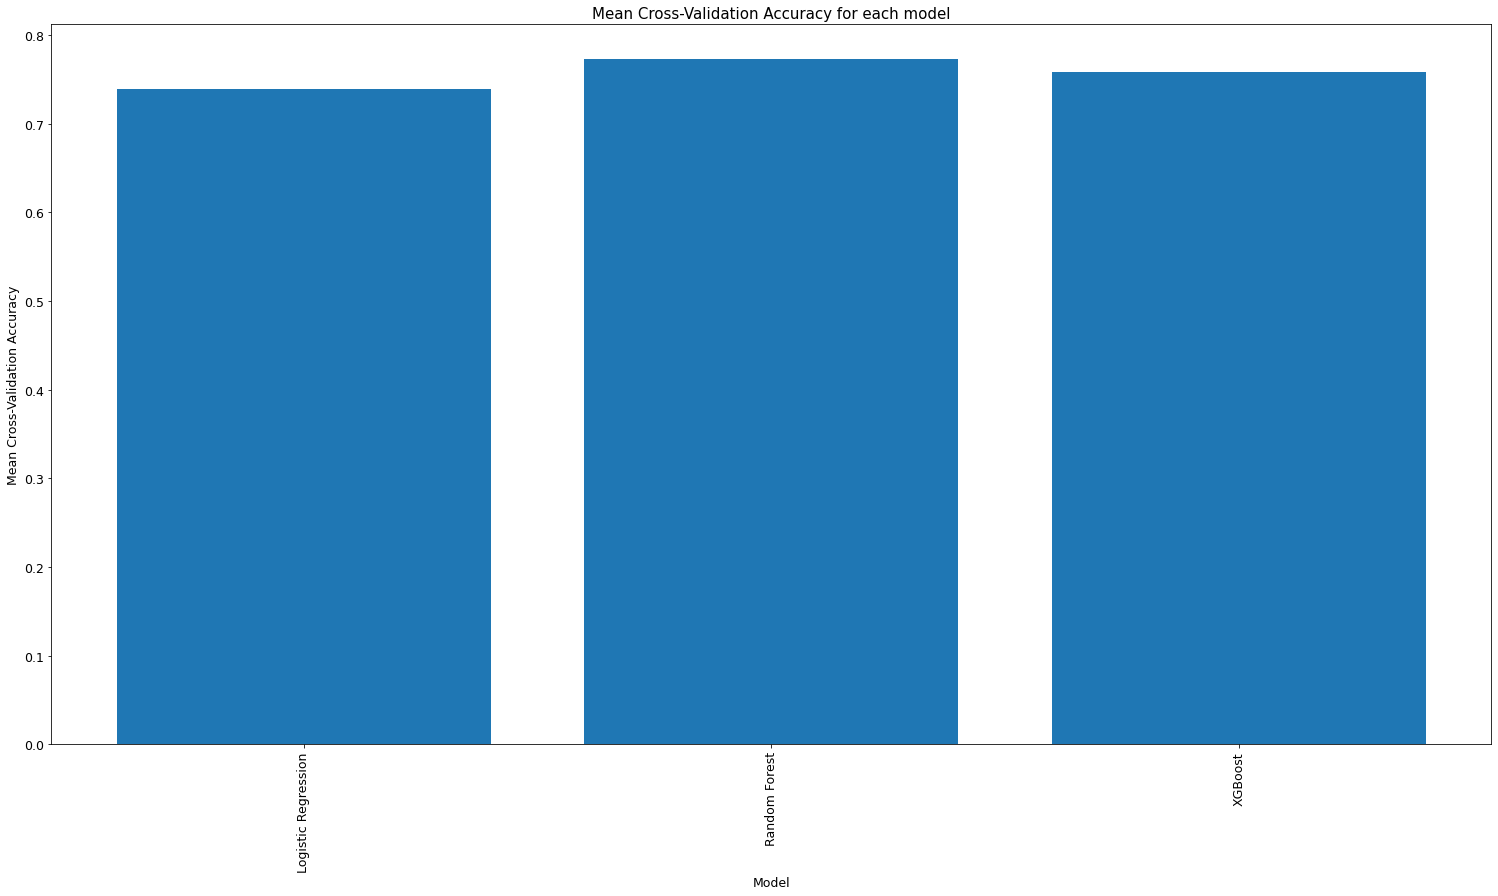

In [397]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy_scores = [cv_score_accuracy.mean(), cv_score_accuracy_rf.mean(), cv_score_accuracy_xgb.mean()]

ax.bar(legend, accuracy_scores)
plt.xticks(rotation=90)
plt.title("Mean Cross-Validation Accuracy for each model")
plt.xlabel("Model")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.show()

In [398]:
accuracy_scores

[0.7394668436480284, 0.7733864277418284, 0.7584702173552348]

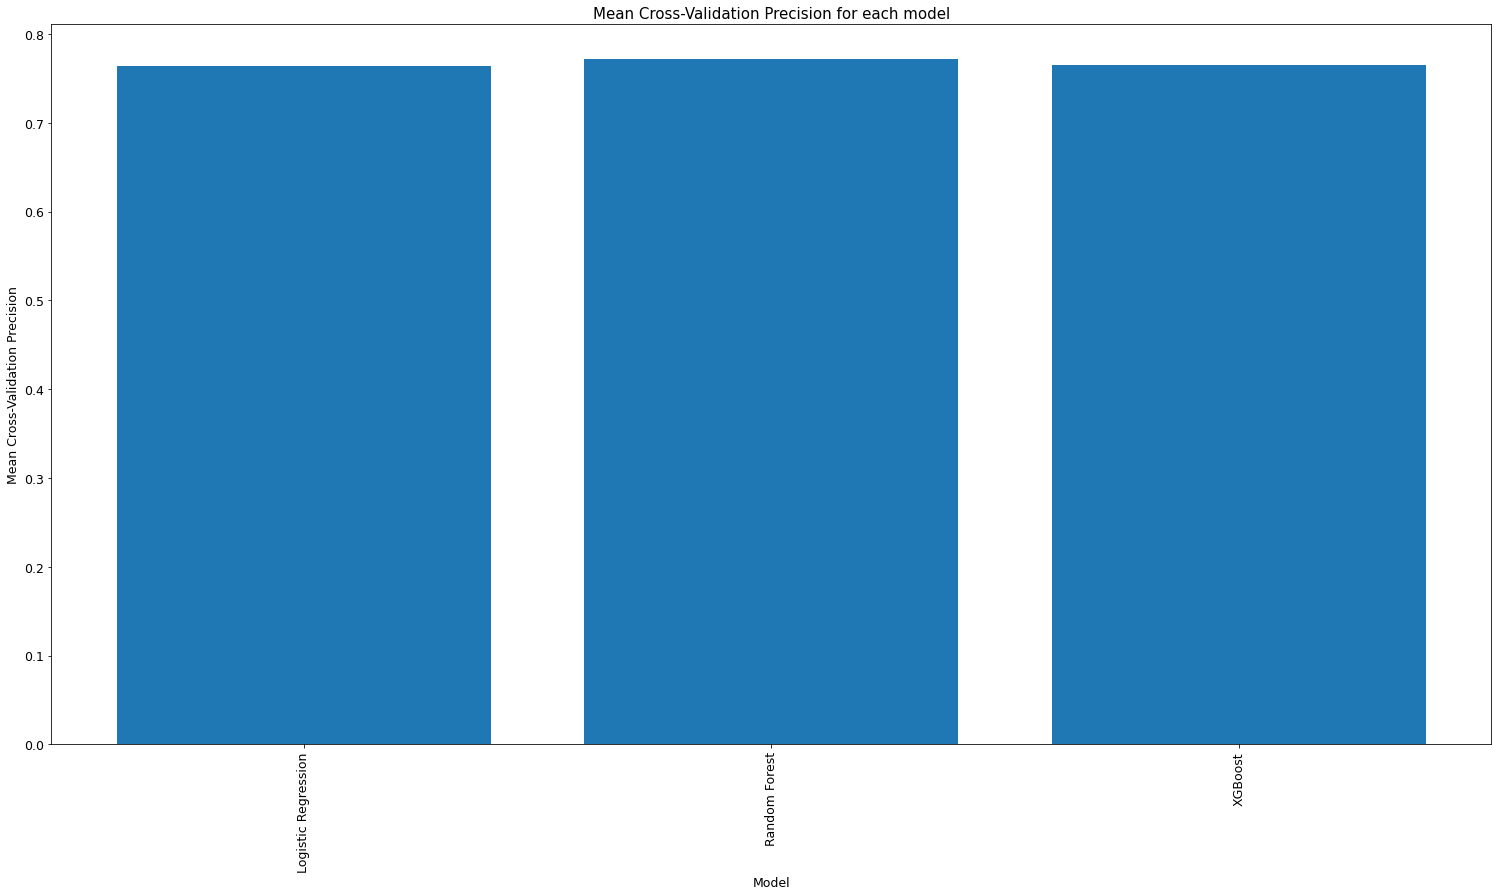

In [399]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = ['Logistic Regression', 'Random Forest', 'XGBoost']
precision_scores = [cv_score_precision.mean(), cv_score_precision_rf.mean(), cv_score_precision_xgb.mean()]

ax.bar(legend, precision_scores)
plt.xticks(rotation=90)
plt.title("Mean Cross-Validation Precision for each model")
plt.xlabel("Model")
plt.ylabel("Mean Cross-Validation Precision")
plt.show()

In [400]:
precision_scores

[0.7640211991983815, 0.7720823679565104, 0.7651758093382459]

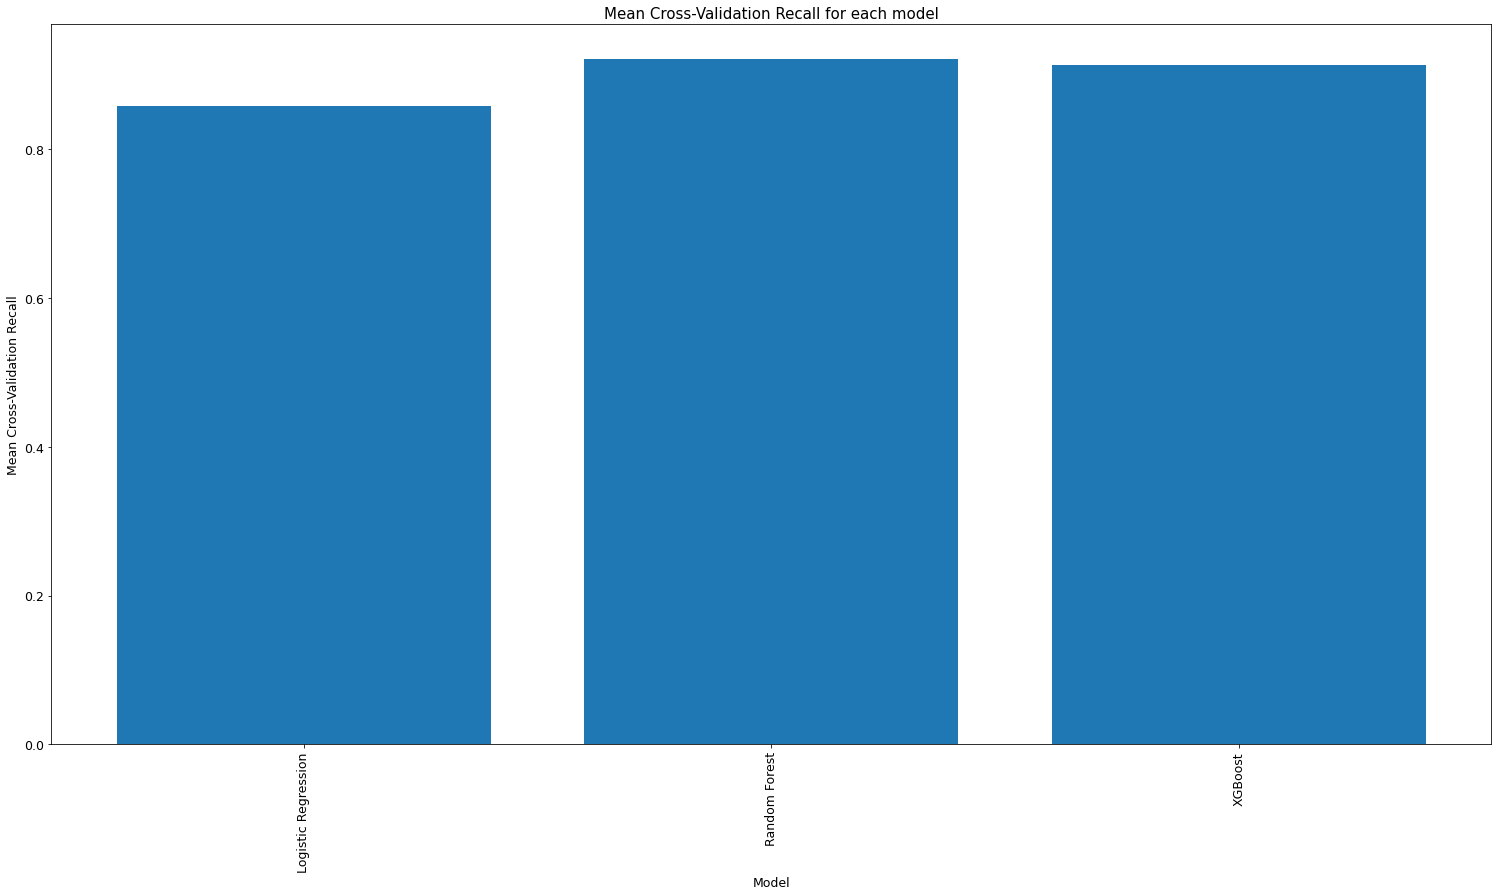

In [401]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = ['Logistic Regression', 'Random Forest', 'XGBoost']
recall_scores = [cv_score_recall.mean(), cv_score_recall_rf.mean(), cv_score_recall_xgb.mean()]

ax.bar(legend, recall_scores)
plt.xticks(rotation=90)
plt.title("Mean Cross-Validation Recall for each model")
plt.xlabel("Model")
plt.ylabel("Mean Cross-Validation Recall")
plt.show()

In [402]:
recall_scores

[0.8577494692144375, 0.9214437367303608, 0.9129511677282377]

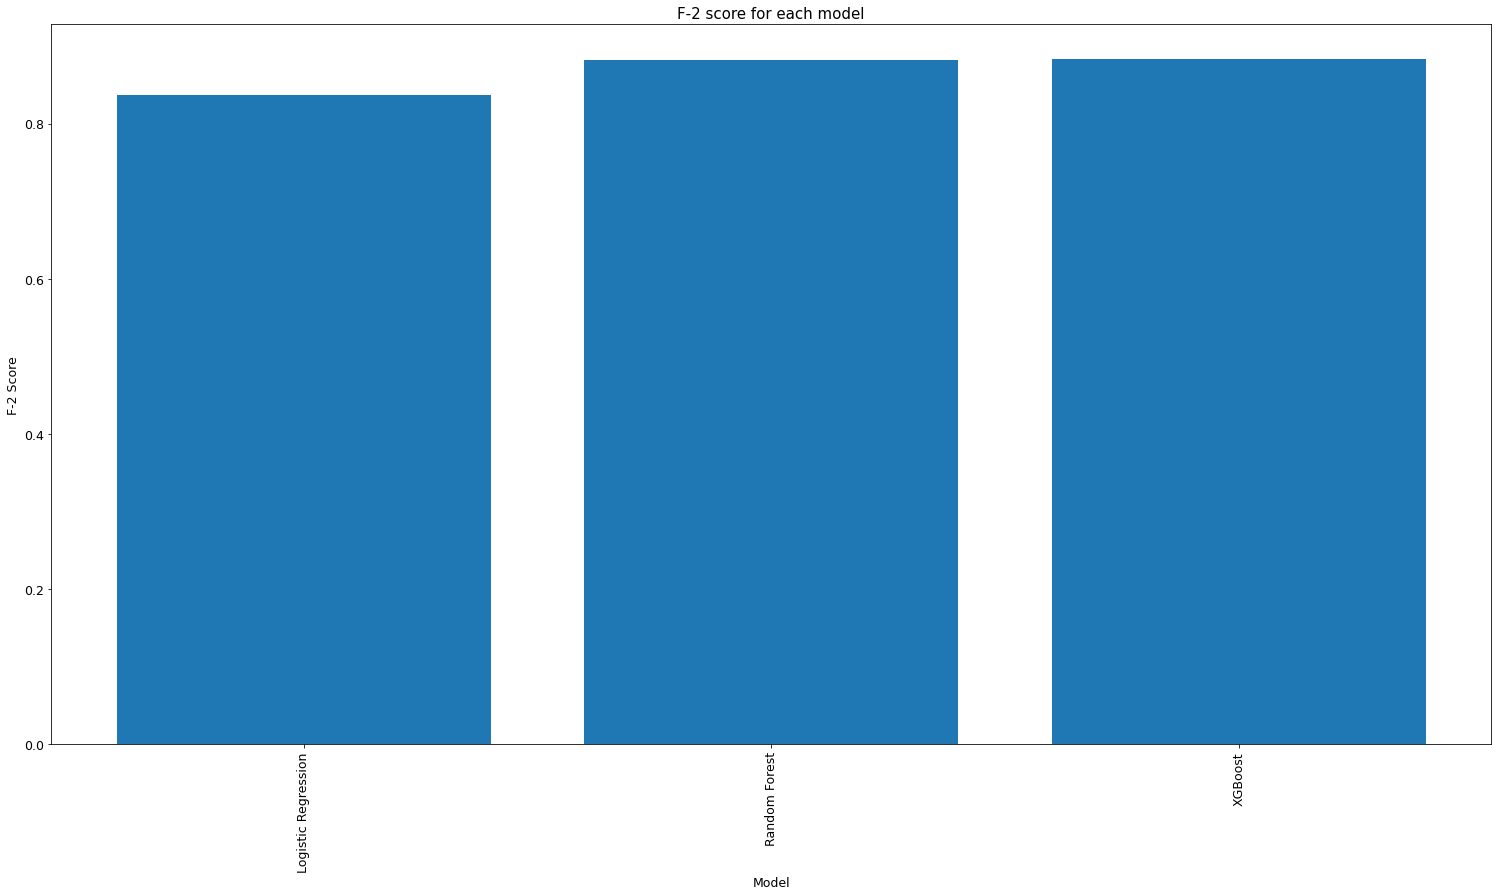

In [403]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = ['Logistic Regression', 'Random Forest', 'XGBoost']
fbeta_scores = [fbeta_score(y_train, yhat, beta = 2), fbeta_score(y_train, yhat_rf, beta = 2), fbeta_score(y_train, yhat_xgbcl, beta = 2)]

ax.bar(legend, fbeta_scores)
plt.xticks(rotation=90)
plt.title("F-2 score for each model")
plt.xlabel("Model")
plt.ylabel("F-2 Score")
plt.show()

In [404]:
fbeta_scores

[0.8371322005801907, 0.8821121571837905, 0.8835504885993485]

In [405]:
best_model = xgbcl
thresholds_dict = {LR: 0, rf: 1, xgbcl: 2}
threshold = final_thresholds[thresholds_dict[best_model]]

In [406]:
threshold

0.39

In [407]:
funding_df = pd.read_csv('funding-data.csv')

In [408]:
mean_payoff = funding_df[funding_df['price_amount'] > 0]['price_amount'].mean()
mean_investment = funding_df[funding_df['funding_total_usd'] > 0]['funding_total_usd'].mean()

In [409]:
mean_payoff, mean_investment

(230637471.26436782, 20618842.774626866)

In [410]:
def cost(threshold, model, x):
  predict_proba = model.predict_proba(x_train)[:, 1]
  predictions = (predict_proba >= threshold).astype(int)

  cm = confusion_matrix(y_train, predictions)

  z = cm[0, 0]
  x = cm[1, 0]
  y = cm[0, 1]
  w = cm[1, 1]
  
  if y+w == 0:
    condition1 = 0
  else:
    condition1 = y/(y+w)
  
  if z+x == 0:
    condition2 = 0
  else:
    condition2 = x/(z+x)

  return condition1 * mean_investment + condition2 * mean_payoff

In [411]:
thresholds = [i/100 for i in range(0, 110)]
costs = [cost(i, best_model, x_train) for i in thresholds]
threshold = thresholds[np.argmin(costs)]
np.min(costs), threshold

(6462173.755896174, 0.32)

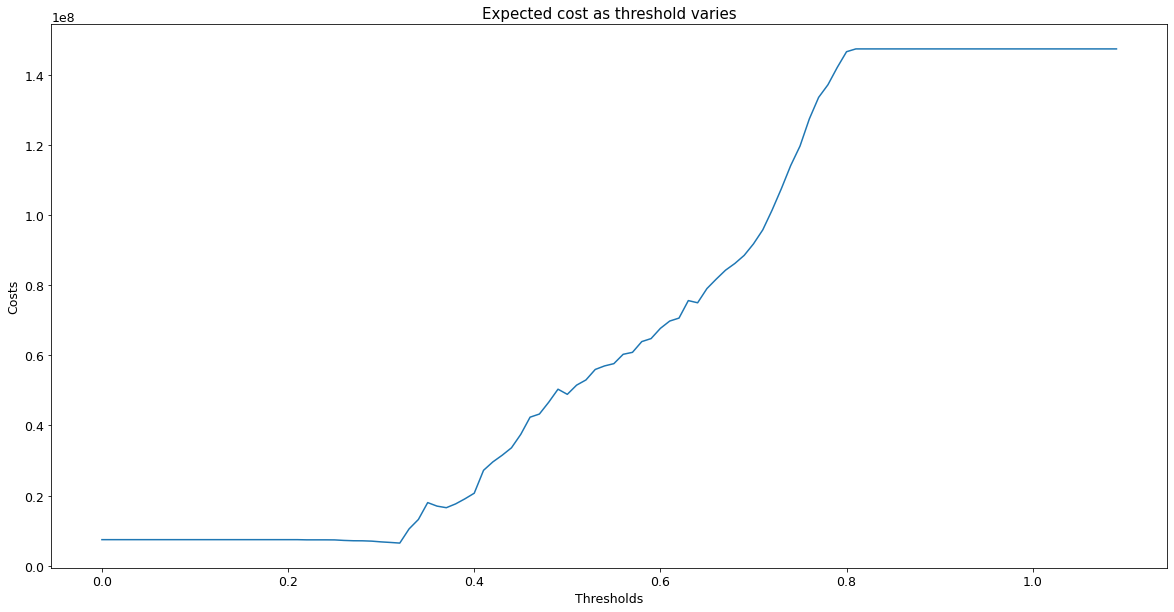

In [412]:
plt.plot(thresholds, costs)
plt.xlabel('Thresholds')
plt.ylabel('Costs')
plt.title('Expected cost as threshold varies')
plt.show()

#Feature Importance

In [413]:
x_labels = x_train.columns
feature_importance = (best_model.feature_importances_)

# Finding the importance of each labels
frame = {"labels": x_labels, "importance": feature_importance}

df_importance = pd.DataFrame(frame)
df_importance_sorted = df_importance.sort_values(by = "importance", ascending = False).reset_index(drop=True)
display(df_importance_sorted)

,labels,importance
0,age_last_milestone_year,0.22
1,relationships,0.19
2,age_first_milestone_year,0.17
3,milestone_none,0.07
4,milestones,0.06
5,avg_participants,0.06
6,age_first_funding_year,0.06
7,funding_total_usd,0.05
8,funding_rounds,0.05
9,age_last_funding_year,0.05


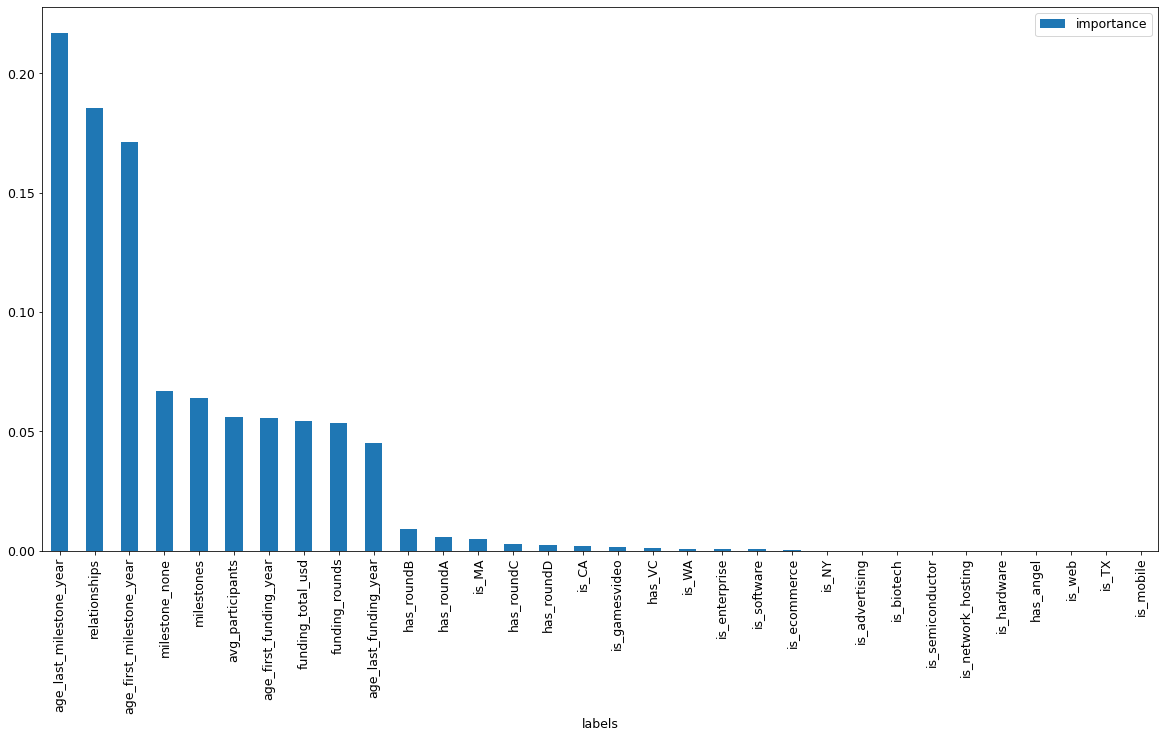

In [414]:
df_importance_sorted.plot.bar(x='labels')
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['font.size'] = '20'

In [415]:
predictions = (best_model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

train_accuracy = np.sum((best_model.predict_proba(x_train)[:, 1] >= threshold).astype(int) == y_train) / len(y_train)
test_accuracy = np.sum(predictions == y_test) / len(y_test)

roc = roc_auc_score(y_test, best_model.predict_proba(x_test)[:, 1])
prec = precision_score(y_test, predictions)
rec = recall_score(y_test, predictions)
f2 = fbeta_score(y_test, predictions, beta = 2)

predictions_tr = (best_model.predict_proba(x_train)[:, 1] >= threshold).astype(int)
roc_tr = roc_auc_score(y_train, best_model.predict_proba(x_train)[:, 1])
prec_tr = precision_score(y_train, predictions_tr)
rec_tr = recall_score(y_train, predictions_tr)
f2_tr = fbeta_score(y_train, predictions_tr, beta = 2)

print("Training Accuracy: " + str(train_accuracy))
print("Testing Accuracy: " + str(test_accuracy))
print("Training AUC Score : " + str(roc_tr))
print("Testing AUC Score : " + str(roc))
print("Training Precision Score: " + str(prec_tr))
print("Testing Precision Score: " + str(prec))
print("Training Recall Score: " + str(rec_tr))
print("Testing Recall Score: " + str(rec))
print("Training F2 Score: " + str(f2_tr))
print("Testing F2 Score: " + str(f2))

fpr, tpr, _ = metrics.roc_curve(y_test, best_model.predict_proba(x_test)[:, 1])

Training Accuracy: 0.7082767978290366
Testing Accuracy: 0.7391304347826086
Training AUC Score : 0.8302643551554044
Testing AUC Score : 0.8296370967741935
Training Precision Score: 0.6865889212827988
Testing Precision Score: 0.7235294117647059
Training Recall Score: 1.0
Testing Recall Score: 0.9919354838709677
Training F2 Score: 0.9163424124513618
Testing F2 Score: 0.9234234234234234


#Confusion Matrix

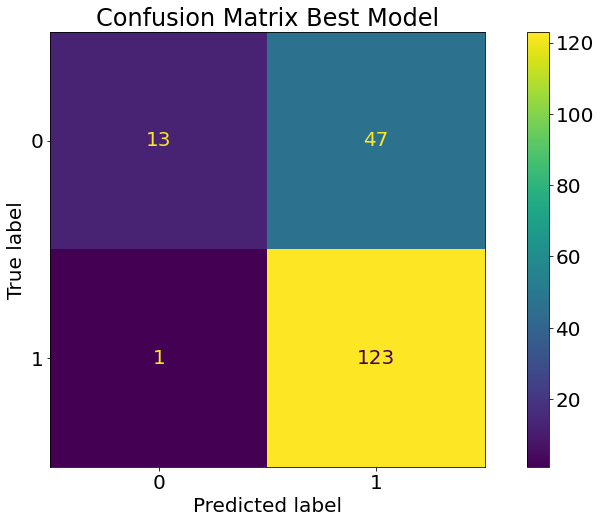

In [416]:
cm = metrics.confusion_matrix(y_test, predictions)

# displays confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(15, 8))
disp1.plot(ax=ax)
plt.title("Confusion Matrix Best Model")

plt.rcParams['font.size'] = '20'
plt.show()

#Error Analysis

In [417]:
df['yhat'] = (best_model.predict_proba(df[X])[:, 1] >= threshold).astype(int)

In [418]:
df_errors = df.loc[df['yhat'] != df['success']]
df_errors['success'].value_counts()

0    262
1      1
Name: success, dtype: int64

In [419]:
funding_df = funding_df[['acquired_object_id', 'price_amount']]
funding_df

,acquired_object_id,price_amount
0,c:1001,47500000
1,c:10153,0
2,c:10158,36500000
3,c:10176,1200000000
4,c:10197,215000000
...,...,...
665,c:9668,0
666,c:967,689000000
667,c:971,190000000
668,c:9730,0


In [420]:
# merging funding df to get the aquisition prices
df_errors = df_errors.merge(funding_df, how='left', left_on='id', right_on='acquired_object_id')
df_errors.loc[df_errors['success'] == 1]

,state_code,latitude,longitude,zip_code,id,city,name,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status,milestone_none,success,is_WA,is_semiconductor,is_network_hosting,is_hardware,yhat,acquired_object_id,price_amount
112,NY,40.83,-73.47,11797,c:39283,Woodbury,Cloverleaf Communications,1/1/2001,NaN,6/28/2005,6/28/2005,4.49,4.49,0.00,0.00,2,1,11000000,0,0,1,0,0,0,public_relations,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3.00,1,acquired,1,1,0,0,0,0,0,c:39283,12000000


The one false negative we predicted is for a startup that was acquired for \$12 million but had \$11 million in total funding. This is a relatively small success (especially when compared to unicorns) so missing out on this company would only have a small opportunity cost for a VC fund.

In [421]:
top_10_industries = df['category_code'].value_counts().head(10).keys()
top_10_industries

Index(['software', 'web', 'mobile', 'enterprise', 'advertising', 'games_video',
       'semiconductor', 'network_hosting', 'biotech', 'hardware'],
      dtype='object')

In [422]:
df_errors['category_code'].isin(top_10_industries)

0       True
1       True
2       True
3      False
4       True
       ...  
258     True
259     True
260     True
261    False
262     True
Name: category_code, Length: 263, dtype: bool

In [423]:
df_errors['category_code'].isin(top_10_industries)

0       True
1       True
2       True
3      False
4       True
       ...  
258     True
259     True
260     True
261    False
262     True
Name: category_code, Length: 263, dtype: bool

In [424]:
df_errs_top_10_industry = df_errors.loc[(df_errors['category_code'].isin(top_10_industries))]
df_top_10_industry = df.loc[(df['category_code'].isin(top_10_industries))]

Text(0.5, 1.0, 'Error Proportion by Industry')

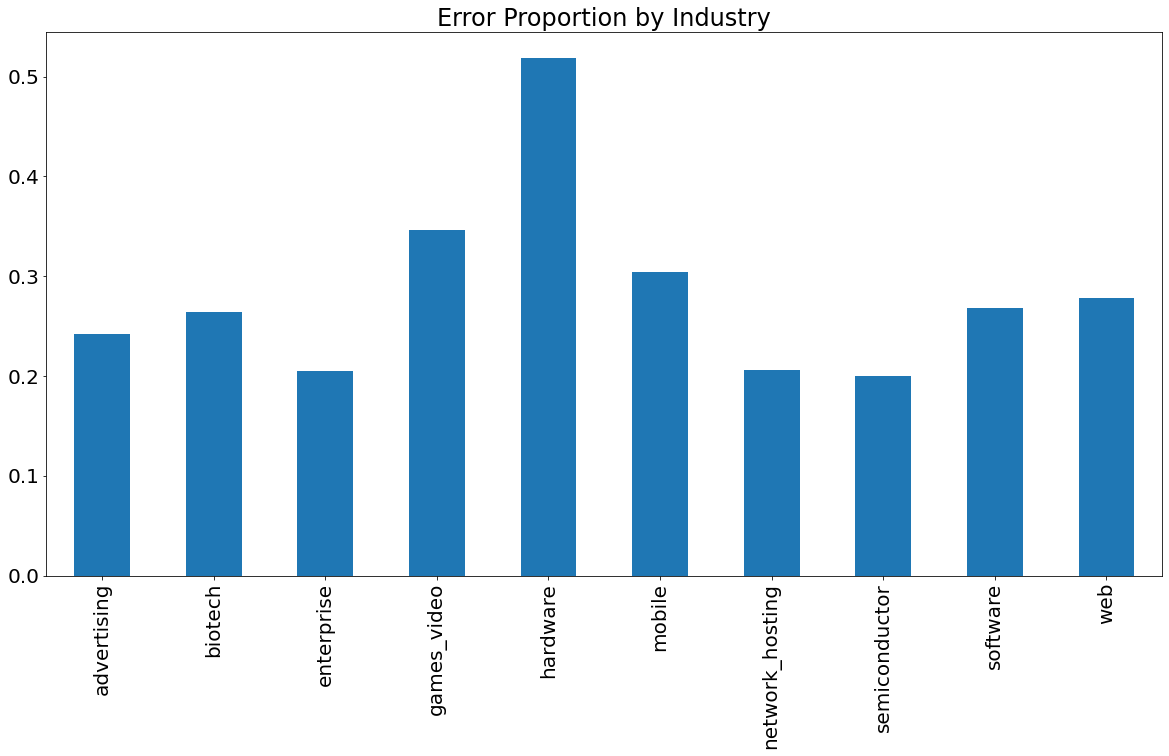

In [425]:
err_by_industry = (df_errs_top_10_industry['category_code'].value_counts() / df_top_10_industry['category_code'].value_counts())
err_by_industry.plot.bar()
plt.title("Error Proportion by Industry")

Our model performed markedly worse on hardware companies. This makes sense since we previously noted that hardware has much lower success rates, likely due to its more capital and R&D intensive nature. Thus, our model may not be able to accomodate for differing trends in the hardware industry.

#ROC Curves

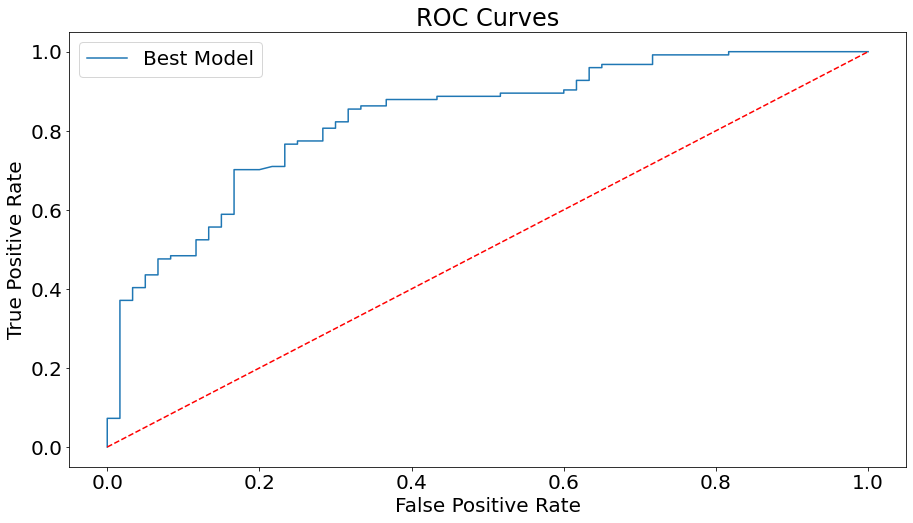

In [426]:
# ROC Curve
ax = plt.subplots(figsize = (15, 8))
ax = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
legend = ["Best Model"]

plt.title('ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(legend)
plt.rcParams['font.size'] = '30'
plt.show()

In [427]:
difference = pd.Series(best_model.predict_proba(x_test)[:, 1] - threshold)
cat1 = difference[difference > 0.50]
cat2 = difference[difference > 0.25]
cat3 = difference[difference < 0]

In [428]:
cat1,cat2,cat3

(Series([], dtype: float64), 0     0.42
 1     0.45
 2     0.48
 3     0.44
 4     0.43
       ... 
 178   0.39
 180   0.46
 181   0.42
 182   0.41
 183   0.43
 Length: 135, dtype: float64, 17    -0.01
 33    -0.03
 35    -0.01
 37    -0.03
 42    -0.05
 55    -0.06
 61    -0.04
 62    -0.00
 75    -0.03
 77    -0.10
 115   -0.02
 123   -0.08
 158   -0.01
 170   -0.02
 dtype: float64)